# Install

In [103]:
# ! pip install pyldavis
# ! pip install openpyxl

In [ ]:

# !pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz --user



In [17]:
oldDataFileName = "../../data/sentences-" + datetime.datetime.now().strftime("%Y%m%d")
runFineTuning = False
numberOfTopics = 14
alpha = 0.91
eta = 0.91
oldDataFileName

'../../data/sentences-20200424'

In [4]:
from gensim.models import TfidfModel
from gensim.models import Word2Vec
from gensim.models import LdaMulticore
import gensim.corpora as corpora
from gensim.utils import ClippedCorpus
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim import matutils

import pyLDAvis.gensim
import datetime
from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np 
import pandas as pd
import json
import random
import matplotlib.pyplot as plt
import itertools

In [ ]:
# nltk.download('averaged_perceptron_tagger')

# Lessons Data

In [10]:
forecastsFilename = oldDataFileName
forecastsData = pd.read_excel(forecastsFilename + ".xlsx")
lessonsData = forecastsData[forecastsData['isLesson'] == True]
lessonsData = lessonsData[lessonsData['machine generated'] == lessonsData['machine generated']]

In [11]:
raw_sentences = lessonsData['machine generated']
raw_paragraphs = lessonsData['paragraph']
fileNames = lessonsData['File Names']
raw_sentences = raw_paragraphs
ids = lessonsData['id']

# Input Preprocessing

In [12]:
# inputFileName = '../data/paragraphs.in'
# inputFileName = 'lessons-20200124.in'
# inputFile = open(inputFileName, "r")
# raw_sentences = [line for line in inputFile.readlines()]
sentences = [line.split(' ') for line in raw_sentences]
# raw_sentences = raw_sentences[0:100]
# sentences = sentences[0:100]
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'äô', 'äù', 'äì'])
words_to_remove = ['iii', 'project']

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def remove_words(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in words_to_remove] for doc in texts]

def remove_word_length_2(texts):
    allSentences = []
    for doc in texts:
        newWords = []
        for word in doc:
            if len(word) > 2:
                newWords.append(word)
        allSentences.append(newWords)
    return allSentences
#     return [[word for word in str(doc) if len(word) > 2] for doc in texts]

def replace_adb_special_characters(texts):
    return [[word.replace('‚Äôs', "'s ").replace('O‚ÄôSmach', "0").replace('äù', "").replace('äô', "").replace('äì', "") for word in doc] for doc in texts]

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

sentences = replace_adb_special_characters(sentences)
data_words_nostops = remove_stopwords(sentences)
lemmatizer = WordNetLemmatizer()
lemmatized_output = []
# print(data_words_nostops[:5])
for paragraph in data_words_nostops:
    lemmatized_output.append([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in paragraph])
# print(lemmatized_output[:5])
sentences = remove_words(lemmatized_output)
sentences_no_length_2 = remove_word_length_2(sentences)
sentences = sentences_no_length_2

In [13]:
id2word = corpora.Dictionary(sentences)
texts = sentences
corpus = [id2word.doc2bow(text) for text in texts]

In [18]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=id2word,
                             num_topics=k, 
                             random_state=100,
                             chunksize=100,
                             passes=10,
                             alpha=a,
                             eta=b,
                             per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=sentences, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

# Fine Tuning

In [125]:
if runFineTuning:
    import numpy as np
    import pandas as pd
    import tqdm
    grid = {}
    grid['Validation_Set'] = {}
    # Topics range
    min_topics = 2
    max_topics = 15
    step_size = 1
    topics_range = range(min_topics, max_topics, step_size)
    # Alpha parameter
    alpha = list(np.arange(0.01, 1, 0.3))
    alpha.append('symmetric')
    alpha.append('asymmetric')
    # Beta parameter
    beta = list(np.arange(0.01, 1, 0.3))
    beta.append('symmetric')
    # Validation sets
    num_of_docs = len(corpus)
    corpus_sets = [
    #                ClippedCorpus(corpus, int(num_of_docs*0.25)), 
                   ClippedCorpus(corpus, int(num_of_docs*0.5)), 
    #                ClippedCorpus(corpus, int(num_of_docs*0.75)), 
                   corpus
                  ]
    corpus_title = [
                    '25% Corpus'
                    '50% Corpus', 
                    '75% Corpus'
                    '100% Corpus'
                   ]
    model_results = {'Validation_Set': [],
                     'Topics': [],
                     'Alpha': [],
                     'Beta': [],
                     'Coherence': []
                    }
    # # Can take a long time to run
    if 1 == 1:
        pbar = tqdm.tqdm(total=2000)

        # iterate through validation corpuses
        for i in range(len(corpus_sets)):
            # iterate through number of topics
            for k in topics_range:
                # iterate through alpha values
                for a in alpha:
                    # iterare through beta values
                    for b in beta:
                        # get the coherence score for the given parameters
                        cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                      k=k, a=a, b=b)
                        # Save the model results
                        model_results['Validation_Set'].append(corpus_title[i])
                        model_results['Topics'].append(k)
                        model_results['Alpha'].append(a)
                        model_results['Beta'].append(b)
                        model_results['Coherence'].append(cv)

                        pbar.update(1)
        pd.DataFrame(model_results).to_csv(oldDataFileName + '-fine-tuning-.csv', index=False)

 39%|███▉      | 780/2000 [4:59:43<9:46:53, 28.86s/it]

# Single Run

In [18]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=numberOfTopics, 
                         random_state=200,
                         chunksize=100,
                         passes=10,
                         alpha=alpha,
                         eta=eta,
                         per_word_topics=True)


In [127]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=sentences, dictionary=id2word, coherence='c_v')
coherence_model_lda.get_coherence()

0.4423265018478384

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.226753 -0.008551       1        1  19.967861
6     -0.148977  0.128479       2        1  13.685961
13    -0.102606 -0.125800       3        1  10.292571
7     -0.093109 -0.009298       4        1   8.396297
3     -0.043908  0.167825       5        1   8.182112
10    -0.053456 -0.130698       6        1   7.995439
5     -0.009646 -0.018591       7        1   7.186955
9      0.035703 -0.074938       8        1   6.182677
1      0.038072  0.025617       9        1   4.924244
4      0.093660 -0.004680      10        1   3.852266
8      0.114196  0.049000      11        1   3.814895
12     0.127135  0.005546      12        1   2.301018
0      0.133656 -0.000225      13        1   1.665206
2      0.136032 -0.003685      14        1   1.552505, topic_info=                Term         Freq        Total Category  logprob  loglift
280      performance  1684.000000  1684.000000  Default  30.0000  30.0000
168          program  4379.000000  4379.000000  Default  29.0000  29.0000
301           reform  2929.000000  2929.000000  Default  28.0000  28.0000
28    implementation  3923.000000  3923.000000  Default  27.0000  27.0000
132             loan  2148.000000  2148.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
6565      publishing     1.697017    40.533485  Topic14  -8.5519   0.9920
9038           ncrpb     1.754764    82.847176  Topic14  -8.5185   0.3106
8681     efficacious     1.475946    29.370253  Topic14  -8.6915   1.1746
6301            psme     1.499385    72.039787  Topic14  -8.6757   0.2931
365         database     1.474994    79.018074  Topic14  -8.6921   0.1843

[777 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
334       1  0.026560  access
334       2  0.002043  access
334       3  0.523029  access
334       4  0.004086  access
334       5  0.002043  access
...     ...       ...     ...
405      10  0.008549    year
405      11  0.321046    year
405      12  0.000950    year
405      13  0.000950    year
405      14  0.000950    year

[9212 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 7, 14, 8, 4, 11, 6, 10, 2, 5, 9, 13, 1, 3])

In [22]:
lda_model.show_topics(num_topics=numberOfTopics, num_words=50,formatted=False)

034145446),
   ('breach', 0.00034036618),
   ('submission', 0.0003369677),
   ('ifrs', 0.00032493114),
   ('nppmb', 0.0003071595),
   ('tim', 0.00030411925),
   ('stake', 0.00030261246),
   ('tpmb', 0.00029765524),
   ('bpmo', 0.0002799651),
   ('sumber', 0.00027323424),
   ('pengelolaan', 0.00027321605),
   ('koordinasi', 0.00027321526),
   ('daya', 0.00027321064),
   ('lec', 0.0002727061),
   ('bappenas', 0.00025648723),
   ('monitoring', 0.00025411803),
   ('rectify', 0.0002512204),
   ('requirement', 0.00024246651),
   ('pkps', 0.00023815682),
   ('acceptable', 0.00023746766),
   ('vnr', 0.0002361187),
   ('follow', 0.00023599746),
   ('filing', 0.00023555866)]),
 (1,
  [('maintenance', 0.032727193),
   ('road', 0.028220497),
   ('covenant', 0.023112524),
   ('budget', 0.017093446),
   ('maintain', 0.013082583),
   ('government', 0.012952565),
   ('fund', 0.012839469),
   ('sustainability', 0.010763942),
   ('compliance', 0.01072504),
   ('monitor', 0.009257813),
   ('annual', 0.00

# TFIDF model

In [25]:
tfidf = TfidfModel(corpus, smartirs='ntc')

tfidf_corpus = []
for doc in corpus:
    tfidf_corpus.append(tfidf[doc])

tfidf_mat = matutils.corpus2dense(tfidf_corpus, num_terms=len(id2word.token2id))

In [32]:
tfidf_mat_transpose = tfidf_mat.transpose()
dfTFIDF=pd.DataFrame(data=tfidf_mat_transpose[0:,0:],
                     index=[i for i in range(tfidf_mat_transpose.shape[0])],
                     columns=[''+str(i) for i in range(tfidf_mat_transpose.shape[1])])
print(dfTFIDF.head(5))

          0         1         2         3         4         5         6  \
0  0.097373  0.113652  0.051593  0.174890  0.156489  0.178773  0.081078   
1  0.066938  0.195323  0.000000  0.000000  0.000000  0.000000  0.167209   
2  0.000000  0.067452  0.000000  0.000000  0.000000  0.000000  0.096239   
3  0.000000  0.057502  0.000000  0.088486  0.000000  0.000000  0.000000   
4  0.000000  0.140477  0.000000  0.216171  0.096713  0.000000  0.100215   

          7         8         9  ...  13297  13298  13299  13300  13301  \
0  0.101889  0.154405  0.101555  ...    0.0    0.0    0.0    0.0    0.0   
1  0.000000  0.141527  0.000000  ...    0.0    0.0    0.0    0.0    0.0   
2  0.000000  0.122186  0.241090  ...    0.0    0.0    0.0    0.0    0.0   
3  0.000000  0.000000  0.205528  ...    0.0    0.0    0.0    0.0    0.0   
4  0.000000  0.063617  0.000000  ...    0.0    0.0    0.0    0.0    0.0   

   13302  13303  13304  13305  13306  
0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0

In [34]:
print(len(dfTFIDF))
dfTFIDF['id'] = ids.tolist()

10789


In [36]:
dfTFIDF.to_csv(oldDataFileName + '-tfidf.csv')
# dfTFIDF.to_excel('../../data/tfidf.xlsx')
# dfTFIDF.to_pickle("../../data/tfidf.pkl")

# Ids and paragraphs

In [16]:
df = pd.DataFrame()
df['id'] = ids
df['paragraph'] = raw_paragraphs
# df.to_csv('../data/lessons_ids_paragraphs.csv')

# Save weights of keywords

In [25]:
x=lda_model.show_topics(num_topics=numberOfTopics, num_words=50,formatted=False)
keywordWeights = []
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
for tp in x:
    words = []
    weights = []
    for pair in tp[1]:
        words.append(pair[0])
        weights.append(int(pair[1]*10000))
    keywordWeights.append(weights)
len(keywordWeights)
# f = open("../../data/topicWords.txt", "w")
# for topic, words in topics_words:
#     print(" ".join(words))
#     f.write(" ".join(words) + '\n')
# f.close()

14

# Assign most probable cluster to each paragraph

In [21]:
df = pd.DataFrame()
df['id'] = ids
df['paragraph'] = raw_paragraphs
len(df)
topicNumbers = []
for c in range(len(corpus)):
    maxProbability = 0
    indexOfMax = 0
    for i, t in zip(range(10), lda_model.get_document_topics(corpus[c])):
        if t[1] > maxProbability:
            maxProbability = t[1]
            indexOfMax = i
    topicNumbers.append(indexOfMax)
df['topic'] = topicNumbers

# Assigned clusters (sorted by probabilities) for each paragraph

In [22]:
topicNumbers = []
for c in range(len(corpus)):
    maxProbability = 0
    indexOfMax = 0
    topTopics = []
    topTopicProbabilities = []
    lda_model.get_document_topics(corpus[c])
    for topicNumber in lda_model.get_document_topics(corpus[c]):
        topTopics.append(topicNumber[0])
        topTopicProbabilities.append(topicNumber[1])
    topTopicsSorted = [x for _,x in sorted(zip(topTopicProbabilities, topTopics), reverse=True)]
    topicNumbers.append(topTopicsSorted)
print(len(topicNumbers))
df['topTopics'] = topicNumbers
df
# df.to_csv("lesson_topics.csv")

10682


id                                          paragraph  topic  \
0          1  Realistic sector and institutional assessments...      6   
1          2  Dedicated gender equity support. Capacity buil...      4   
2          3  Challenging loan covenants. The borrower faile...      6   
3          4  Separate project completion reports for multit...      6   
4          5  In-depth assessments and project readiness. Tr...      6   
...      ...                                                ...    ...   
55309  57975  There was also delay in activities under compo...      7   
55314  57980  Improve legal procedures for calling up defaul...      4   
55315  57981  Improve valuation system of land and houses to...      4   
55324  57990  The project can be considered efficient consid...      6   
55325  57991  The government in May 2013 announced a scheme ...      4   

                                            topTopics  
0      [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]  
1                          [6, 5, 11, 1, 0, 13, 4, 7]  
2      [6, 0, 13, 11, 4, 7, 5, 8, 10, 12, 9, 3, 2, 1]  
3      [6, 11, 1, 13, 3, 7, 4, 5, 0, 2, 12, 8, 10, 9]  
4      [6, 7, 13, 0, 4, 5, 11, 9, 1, 3, 10, 12, 8, 2]  
...                                               ...  
55309  [7, 13, 8, 4, 6, 5, 11, 1, 0, 9, 3, 2, 12, 10]  
55314  [4, 7, 13, 9, 6, 1, 0, 5, 11, 2, 8, 3, 12, 10]  
55315  [4, 9, 5, 11, 6, 8, 7, 13, 0, 1, 3, 10, 12, 2]  
55324  [6, 13, 11, 7, 1, 3, 5, 0, 4, 10, 12, 9, 8, 2]  
55325  [4, 9, 0, 11, 7, 5, 13, 6, 1, 2, 12, 8, 10, 3]  

[10682 rows x 4 columns]

# Assign most probable cluster to each paragraph

In [26]:
topTopics = []

for index, row in df.iterrows():
    if(row['topTopics']):
        topTopics.append(row['topTopics'][0])
    else:
        topTopics.append(-1)

df['topic'] = topTopics

# Get frequencies of topics

In [26]:
topics = pd.DataFrame()

topicKeywords = []
allKeywords = []
topicIds = []
for topic, words in topics_words:
    allKeywords.append(words)
    topicIds.append(topic)
topics['Topic Number'] = topicIds
topics['Keywords'] = allKeywords
topics['Keywords Frequencies'] = [ [0] * len(keywords) for keywords in allKeywords]
topics['Number of Lessons'] = 0
topics['PCRs'] = [[]  for i in range(len(topics))]
topics['Number of PCRs'] = 0

for sentenceTopicNumbers, sentenceFileName in zip(topicNumbers, fileNames):
    for topicNumber in sentenceTopicNumbers:
        topics.at[topicNumber, 'Number of Lessons'] = topics.at[topicNumber, 'Number of Lessons'] + 1
        topics.at[topicNumber, 'PCRs'].append(sentenceFileName)
for index, row in topics.iterrows():
    topics.at[index, 'Number of PCRs'] = len(set(topics.at[index, 'PCRs']))
topics = topics.drop(columns=['PCRs'])
topics
# topics.to_csv('topics.csv')

Topic Number                                           Keywords  \
0              0  [loan, financial, covenant, compliance, audit,...   
1              1  [performance, report, evaluation, year, comple...   
2              2  [power, plant, transmission, line, forest, are...   
3              3  [para, general, mff, corporation, tourism, soe...   
4              4  [market, private, sector, credit, bank, financ...   
5              5  [training, school, education, teacher, communi...   
6              6  [implementation, agency, capacity, adb, implem...   
7              7  [road, work, contract, delay, consultant, cons...   
8              8  [island, soes, decree, prime, minister, minist...   
9              9  [land, resettlement, affected, acquisition, pe...   
10            10  [pradesh, madhya, iwrm, basin, trm, andhra, df...   
11            11  [system, water, sustainability, improve, manag...   
12            12  [publishing, rental, printing, textbook, publi...   
13            13  [program, reform, government, policy, developm...   

                                 Keywords Frequencies  Number of Lessons  \
0   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              10459   
1   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              10494   
2   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              10108   
3   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...               9828   
4   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              10647   
5   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              10566   
6   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              10680   
7   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              10625   
8   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...               9829   
9   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              10046   
10  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...               9743   
11  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              10596   
12  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...               9751   
13  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...              10632   

    Number of PCRs  
0              956  
1              960  
2              957  
3              954  
4              960  
5              959  
6              960  
7              958  
8              954  
9              955  
10             954  
11             960  
12             953  
13             960

# Get frequencies of words per sentence and per topic

In [28]:
topics['Keywords Frequencies'] = [ [0] * len(keywords) for keywords in allKeywords]

for index, row in topics.iterrows():
    topicNumber = topics.at[index, 'Topic Number']
    topicKeywords = topics.at[index, 'Keywords']
    topicKeywordsFrequencies = topics.at[index, 'Keywords Frequencies']
    for sentence, sentenceTopicNumbers in zip(sentences, topicNumbers):
        for sentenceTopicNumber in sentenceTopicNumbers:
            if topicNumber == sentenceTopicNumber:
                for word in sentence:
                    if word in topicKeywords:
                        indexOfWord = topicKeywords.index(word)
                        topicKeywordsFrequencies[indexOfWord] = topicKeywordsFrequencies[indexOfWord] + 1
    topics.at[index, 'Keywords Frequencies'] = topicKeywordsFrequencies
topics['Keywords Weights'] = keywordWeights
topics

Topic Number                                           Keywords  \
0              0  [statement, audit, financial, accounting, disc...   
1              1  [maintenance, road, covenant, budget, maintain...   
2              2  [website, grievance, complaint, upload, redres...   
3              3  [loan, delay, adb, implementation, complete, t...   
4              4  [road, construction, rehabilitation, safety, s...   
5              5  [financial, cost, credit, bank, market, loan, ...   
6              6  [implementation, agency, consultant, staff, wo...   
7              7  [government, law, regulation, establish, commi...   
8              8  [performance, report, evaluation, impact, year...   
9              9  [water, system, power, supply, tariff, town, f...   
10            10  [training, school, education, teacher, seconda...   
11            11  [program, reform, government, policy, support,...   
12            12  [land, resettlement, affected, acquisition, pe...   
13            13  [community, private, development, service, sec...   

                                 Keywords Frequencies  Number of Lessons  \
0   [194, 426, 2052, 138, 47, 55, 47, 246, 26, 19,...               9857   
1   [1254, 2037, 1045, 915, 633, 5580, 1517, 1239,...              10567   
2   [69, 30, 25, 9, 19, 10, 175, 4, 23, 29, 7, 3, ...               9798   
3   [2887, 1455, 4184, 4980, 1120, 1614, 675, 525,...              10700   
4   [2037, 1011, 291, 338, 243, 169, 1231, 274, 17...              10326   
5   [2536, 1688, 840, 876, 1295, 2856, 861, 612, 1...              10673   
6   [5028, 2527, 1479, 1735, 1878, 2955, 1529, 244...              10743   
7   [5794, 505, 481, 1256, 459, 667, 1544, 1592, 4...              10695   
8   [2408, 1684, 1336, 1279, 1301, 1963, 526, 900,...              10460   
9   [1064, 2207, 660, 683, 467, 313, 997, 2324, 11...              10530   
10  [1993, 1418, 1267, 1033, 656, 549, 2397, 1101,...              10600   
11  [5336, 3337, 5901, 3011, 3324, 3459, 2913, 426...              10772   
12  [799, 413, 364, 280, 282, 166, 142, 138, 216, ...              10061   
13  [1150, 1256, 3404, 1838, 2893, 895, 1190, 1574...              10734   

    Number of PCRs                                   Keywords Weights  
0              957  [127, 115, 57, 32, 25, 20, 19, 12, 11, 10, 9, ...  
1              963  [327, 282, 231, 170, 130, 129, 128, 107, 107, ...  
2              957  [58, 17, 14, 12, 9, 6, 3, 3, 2, 2, 2, 2, 2, 2,...  
3              961  [331, 197, 159, 150, 116, 115, 89, 86, 85, 79,...  
4              960  [295, 135, 88, 80, 69, 66, 63, 63, 53, 52, 52,...  
5              963  [218, 214, 164, 159, 151, 122, 100, 91, 81, 78...  
6              964  [307, 211, 158, 154, 154, 127, 125, 117, 117, ...  
7              963  [215, 92, 74, 74, 71, 67, 66, 64, 62, 60, 59, ...  
8              963  [702, 516, 381, 202, 156, 154, 148, 127, 116, ...  
9              963  [216, 146, 140, 133, 95, 81, 78, 78, 69, 64, 6...  
10             962  [318, 272, 219, 179, 122, 104, 86, 86, 81, 75,...  
11             964  [337, 249, 214, 205, 161, 140, 117, 100, 95, 9...  
12             958  [402, 187, 178, 125, 75, 68, 67, 54, 44, 44, 3...  
13             964  [153, 145, 141, 120, 118, 112, 100, 85, 79, 77...

# Sort keywords

In [140]:
# for index, row in topics.iterrows():
#     topicKeywordsFrequencies = row['Keywords Frequencies']
#     topicKeywords = row['Keywords']
#     topicKeywordsFrequenciesSorted = sorted(topicKeywordsFrequencies, reverse=True)
#     topicKeywordsSorted = [x for _,x in sorted(zip(topicKeywordsFrequencies, topicKeywords), reverse=True)]
#     topics.at[index, 'Keywords Frequencies'] = topicKeywordsFrequenciesSorted
#     topics.at[index, 'Keywords']  = topicKeywordsSorted
# topics

# Get word with highest frequency for every topic

In [142]:
# topicTopWords = []
# for index, row in topics.iterrows():
#     topicTopWords.append(row['Keywords'][0])
# topics['Top Word'] = topicTopWords
# topics

# Get word with highest weight for every topic

In [29]:
topicTopWords = []
for index, row in topics.iterrows():
    topicTopWords.append(row['Keywords'][0])
topics['Top Word'] = topicTopWords
topics

Topic Number                                           Keywords  \
0              0  [statement, audit, financial, accounting, disc...   
1              1  [maintenance, road, covenant, budget, maintain...   
2              2  [website, grievance, complaint, upload, redres...   
3              3  [loan, delay, adb, implementation, complete, t...   
4              4  [road, construction, rehabilitation, safety, s...   
5              5  [financial, cost, credit, bank, market, loan, ...   
6              6  [implementation, agency, consultant, staff, wo...   
7              7  [government, law, regulation, establish, commi...   
8              8  [performance, report, evaluation, impact, year...   
9              9  [water, system, power, supply, tariff, town, f...   
10            10  [training, school, education, teacher, seconda...   
11            11  [program, reform, government, policy, support,...   
12            12  [land, resettlement, affected, acquisition, pe...   
13            13  [community, private, development, service, sec...   

                                 Keywords Frequencies  Number of Lessons  \
0   [194, 426, 2052, 138, 47, 55, 47, 246, 26, 19,...               9857   
1   [1254, 2037, 1045, 915, 633, 5580, 1517, 1239,...              10567   
2   [69, 30, 25, 9, 19, 10, 175, 4, 23, 29, 7, 3, ...               9798   
3   [2887, 1455, 4184, 4980, 1120, 1614, 675, 525,...              10700   
4   [2037, 1011, 291, 338, 243, 169, 1231, 274, 17...              10326   
5   [2536, 1688, 840, 876, 1295, 2856, 861, 612, 1...              10673   
6   [5028, 2527, 1479, 1735, 1878, 2955, 1529, 244...              10743   
7   [5794, 505, 481, 1256, 459, 667, 1544, 1592, 4...              10695   
8   [2408, 1684, 1336, 1279, 1301, 1963, 526, 900,...              10460   
9   [1064, 2207, 660, 683, 467, 313, 997, 2324, 11...              10530   
10  [1993, 1418, 1267, 1033, 656, 549, 2397, 1101,...              10600   
11  [5336, 3337, 5901, 3011, 3324, 3459, 2913, 426...              10772   
12  [799, 413, 364, 280, 282, 166, 142, 138, 216, ...              10061   
13  [1150, 1256, 3404, 1838, 2893, 895, 1190, 1574...              10734   

    Number of PCRs                                   Keywords Weights  \
0              957  [127, 115, 57, 32, 25, 20, 19, 12, 11, 10, 9, ...   
1              963  [327, 282, 231, 170, 130, 129, 128, 107, 107, ...   
2              957  [58, 17, 14, 12, 9, 6, 3, 3, 2, 2, 2, 2, 2, 2,...   
3              961  [331, 197, 159, 150, 116, 115, 89, 86, 85, 79,...   
4              960  [295, 135, 88, 80, 69, 66, 63, 63, 53, 52, 52,...   
5              963  [218, 214, 164, 159, 151, 122, 100, 91, 81, 78...   
6              964  [307, 211, 158, 154, 154, 127, 125, 117, 117, ...   
7              963  [215, 92, 74, 74, 71, 67, 66, 64, 62, 60, 59, ...   
8              963  [702, 516, 381, 202, 156, 154, 148, 127, 116, ...   
9              963  [216, 146, 140, 133, 95, 81, 78, 78, 69, 64, 6...   
10             962  [318, 272, 219, 179, 122, 104, 86, 86, 81, 75,...   
11             964  [337, 249, 214, 205, 161, 140, 117, 100, 95, 9...   
12             958  [402, 187, 178, 125, 75, 68, 67, 54, 44, 44, 3...   
13             964  [153, 145, 141, 120, 118, 112, 100, 85, 79, 77...   

          Top Word  
0        statement  
1      maintenance  
2          website  
3             loan  
4             road  
5        financial  
6   implementation  
7       government  
8      performance  
9            water  
10        training  
11         program  
12            land  
13       community

# x and y

In [30]:
topics['x'] = 1.0
topics['y'] = 1.0
for topic, x in zip(list(vis.topic_coordinates.index), list(vis.topic_coordinates.x)):
    topics.at[topic, 'x'] = float(x)
for topic, y in zip(list(vis.topic_coordinates.index), list(vis.topic_coordinates.y)):
    topics.at[topic, 'y'] = float(y)

In [31]:
topics

Topic Number                                           Keywords  \
0              0  [statement, audit, financial, accounting, disc...   
1              1  [maintenance, road, covenant, budget, maintain...   
2              2  [website, grievance, complaint, upload, redres...   
3              3  [loan, delay, adb, implementation, complete, t...   
4              4  [road, construction, rehabilitation, safety, s...   
5              5  [financial, cost, credit, bank, market, loan, ...   
6              6  [implementation, agency, consultant, staff, wo...   
7              7  [government, law, regulation, establish, commi...   
8              8  [performance, report, evaluation, impact, year...   
9              9  [water, system, power, supply, tariff, town, f...   
10            10  [training, school, education, teacher, seconda...   
11            11  [program, reform, government, policy, support,...   
12            12  [land, resettlement, affected, acquisition, pe...   
13            13  [community, private, development, service, sec...   

                                 Keywords Frequencies  Number of Lessons  \
0   [194, 426, 2052, 138, 47, 55, 47, 246, 26, 19,...               9857   
1   [1254, 2037, 1045, 915, 633, 5580, 1517, 1239,...              10567   
2   [69, 30, 25, 9, 19, 10, 175, 4, 23, 29, 7, 3, ...               9798   
3   [2887, 1455, 4184, 4980, 1120, 1614, 675, 525,...              10700   
4   [2037, 1011, 291, 338, 243, 169, 1231, 274, 17...              10326   
5   [2536, 1688, 840, 876, 1295, 2856, 861, 612, 1...              10673   
6   [5028, 2527, 1479, 1735, 1878, 2955, 1529, 244...              10743   
7   [5794, 505, 481, 1256, 459, 667, 1544, 1592, 4...              10695   
8   [2408, 1684, 1336, 1279, 1301, 1963, 526, 900,...              10460   
9   [1064, 2207, 660, 683, 467, 313, 997, 2324, 11...              10530   
10  [1993, 1418, 1267, 1033, 656, 549, 2397, 1101,...              10600   
11  [5336, 3337, 5901, 3011, 3324, 3459, 2913, 426...              10772   
12  [799, 413, 364, 280, 282, 166, 142, 138, 216, ...              10061   
13  [1150, 1256, 3404, 1838, 2893, 895, 1190, 1574...              10734   

    Number of PCRs                                   Keywords Weights  \
0              957  [127, 115, 57, 32, 25, 20, 19, 12, 11, 10, 9, ...   
1              963  [327, 282, 231, 170, 130, 129, 128, 107, 107, ...   
2              957  [58, 17, 14, 12, 9, 6, 3, 3, 2, 2, 2, 2, 2, 2,...   
3              961  [331, 197, 159, 150, 116, 115, 89, 86, 85, 79,...   
4              960  [295, 135, 88, 80, 69, 66, 63, 63, 53, 52, 52,...   
5              963  [218, 214, 164, 159, 151, 122, 100, 91, 81, 78...   
6              964  [307, 211, 158, 154, 154, 127, 125, 117, 117, ...   
7              963  [215, 92, 74, 74, 71, 67, 66, 64, 62, 60, 59, ...   
8              963  [702, 516, 381, 202, 156, 154, 148, 127, 116, ...   
9              963  [216, 146, 140, 133, 95, 81, 78, 78, 69, 64, 6...   
10             962  [318, 272, 219, 179, 122, 104, 86, 86, 81, 75,...   
11             964  [337, 249, 214, 205, 161, 140, 117, 100, 95, 9...   
12             958  [402, 187, 178, 125, 75, 68, 67, 54, 44, 44, 3...   
13             964  [153, 145, 141, 120, 118, 112, 100, 85, 79, 77...   

          Top Word         x         y  
0        statement  0.133656 -0.000225  
1      maintenance  0.038072  0.025617  
2          website  0.136032 -0.003685  
3             loan -0.043908  0.167825  
4             road  0.093660 -0.004680  
5        financial -0.009646 -0.018591  
6   implementation -0.148977  0.128479  
7       government -0.093109 -0.009298  
8      performance  0.114196  0.049000  
9            water  0.035703 -0.074938  
10        training -0.053456 -0.130698  
11         program -0.226753 -0.008551  
12            land  0.127135  0.005546  
13       community -0.102606 -0.125800

# Distance

In [32]:
import math  
def calculateDistance(x1,y1,x2,y2):  
     dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
     return dist  

distanceMatrix = []
allDistances = []
c1 = 0
topicsX = topics['x'].tolist()
topicsY = topics['y'].tolist()
for tx1, ty1 in zip(topicsX, topicsY):
    distances = []
    for tx2, ty2 in zip(topicsX, topicsY):
        distance = calculateDistance(tx1, ty1, tx2, ty2)
        if not distance:
            distance = 999
        else:
            allDistances.append(distance)
        distances.append(distance)
    distanceMatrix.append(distances)
    c1 = c1 + 1

Average:0.1792533467855015


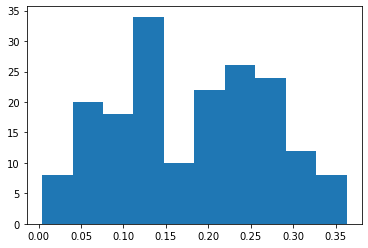

In [37]:
plt.hist(allDistances)
averageDistance = sum(allDistances)/len(allDistances)
print("Average:" + str(averageDistance))

In [120]:
averageDistance = sum(allDistances)/len(allDistances)
percentile25 = np.percentile(allDistances, 20)
numberOfAdjacent = 0
numberOfNodes = len(distanceMatrix)
allAdjacentTopics = []
for distances in distanceMatrix:
    adjacentTopics = []
    for index, distance in zip(range(len(distances)), distances):
        if distance <= percentile25:
            adjacentTopics.append(index)
    allAdjacentTopics.append(adjacentTopics)
    numberOfAdjacent = numberOfAdjacent + len(adjacentTopics)
numberOfAdjacent = numberOfAdjacent/2

[[1, 2, 4, 8, 12], [0, 4, 5, 8, 12], [0, 4, 8, 12], [], [0, 1, 2, 8, 9, 12], [1, 7, 9], [], [5], [0, 1, 2, 4, 12], [4, 5], [13], [], [0, 1, 2, 4, 8], [10]]
91.0
19.0
72.0


In [121]:
pairs = []
for index, adjacentTopicList in zip(range(len(allAdjacentTopics)), allAdjacentTopics):
    for adjacentTopic in adjacentTopicList:
        pairs.append(sorted([index, adjacentTopic]))
pairs.sort()
dedupedPairs = list(pairs for pairs,_ in itertools.groupby(pairs))

[[0, 1], [0, 2], [0, 4], [0, 8], [0, 12], [0, 1], [1, 4], [1, 5], [1, 8], [1, 12], [0, 2], [2, 4], [2, 8], [2, 12], [0, 4], [1, 4], [2, 4], [4, 8], [4, 9], [4, 12], [1, 5], [5, 7], [5, 9], [5, 7], [0, 8], [1, 8], [2, 8], [4, 8], [8, 12], [4, 9], [5, 9], [10, 13], [0, 12], [1, 12], [2, 12], [4, 12], [8, 12], [10, 13]]
38
[[0, 1], [0, 2], [0, 4], [0, 8], [0, 12], [1, 4], [1, 5], [1, 8], [1, 12], [2, 4], [2, 8], [2, 12], [4, 8], [4, 9], [4, 12], [5, 7], [5, 9], [8, 12], [10, 13]]
19


In [122]:
topWordPairs = []
for pair in dedupedPairs:
    topWordPairs.append([topicTopWords[pair[0]], topicTopWords[pair[1]]])

[['statement', 'maintenance'], ['statement', 'website'], ['statement', 'road'], ['statement', 'performance'], ['statement', 'land'], ['maintenance', 'road'], ['maintenance', 'financial'], ['maintenance', 'performance'], ['maintenance', 'land'], ['website', 'road'], ['website', 'performance'], ['website', 'land'], ['road', 'performance'], ['road', 'water'], ['road', 'land'], ['financial', 'government'], ['financial', 'water'], ['performance', 'land'], ['training', 'community']]


In [123]:
nodes = []
links = []
for i, word in zip(range(len(topicTopWords)), topicTopWords):
    nodes.append({"id": word, "group": 1})
for i, pair in zip(range(len(dedupedPairs)), topWordPairs):
    links.append({"source": pair[0], "target": pair[1], "value": 1})

d3Data = {"nodes":nodes, "links":links}
d3DataJSON = json.dumps(d3Data)
with open("../../data/d3DataJSON.json", "w") as outfile: 
    outfile.write(d3DataJSON)

In [128]:
topics['adjacentTopics'] = allAdjacentTopics
topics

Topic Number                                           Keywords  \
0              0  [statement, audit, financial, accounting, disc...   
1              1  [maintenance, road, covenant, budget, maintain...   
2              2  [website, grievance, complaint, upload, redres...   
3              3  [loan, delay, adb, implementation, complete, t...   
4              4  [road, construction, rehabilitation, safety, s...   
5              5  [financial, cost, credit, bank, market, loan, ...   
6              6  [implementation, agency, consultant, staff, wo...   
7              7  [government, law, regulation, establish, commi...   
8              8  [performance, report, evaluation, impact, year...   
9              9  [water, system, power, supply, tariff, town, f...   
10            10  [training, school, education, teacher, seconda...   
11            11  [program, reform, government, policy, support,...   
12            12  [land, resettlement, affected, acquisition, pe...   
13            13  [community, private, development, service, sec...   

                                 Keywords Frequencies  Number of Lessons  \
0   [194, 426, 2052, 138, 47, 55, 47, 246, 26, 19,...               9857   
1   [1254, 2037, 1045, 915, 633, 5580, 1517, 1239,...              10567   
2   [69, 30, 25, 9, 19, 10, 175, 4, 23, 29, 7, 3, ...               9798   
3   [2887, 1455, 4184, 4980, 1120, 1614, 675, 525,...              10700   
4   [2037, 1011, 291, 338, 243, 169, 1231, 274, 17...              10326   
5   [2536, 1688, 840, 876, 1295, 2856, 861, 612, 1...              10673   
6   [5028, 2527, 1479, 1735, 1878, 2955, 1529, 244...              10743   
7   [5794, 505, 481, 1256, 459, 667, 1544, 1592, 4...              10695   
8   [2408, 1684, 1336, 1279, 1301, 1963, 526, 900,...              10460   
9   [1064, 2207, 660, 683, 467, 313, 997, 2324, 11...              10530   
10  [1993, 1418, 1267, 1033, 656, 549, 2397, 1101,...              10600   
11  [5336, 3337, 5901, 3011, 3324, 3459, 2913, 426...              10772   
12  [799, 413, 364, 280, 282, 166, 142, 138, 216, ...              10061   
13  [1150, 1256, 3404, 1838, 2893, 895, 1190, 1574...              10734   

    Number of PCRs                                   Keywords Weights  \
0              957  [127, 115, 57, 32, 25, 20, 19, 12, 11, 10, 9, ...   
1              963  [327, 282, 231, 170, 130, 129, 128, 107, 107, ...   
2              957  [58, 17, 14, 12, 9, 6, 3, 3, 2, 2, 2, 2, 2, 2,...   
3              961  [331, 197, 159, 150, 116, 115, 89, 86, 85, 79,...   
4              960  [295, 135, 88, 80, 69, 66, 63, 63, 53, 52, 52,...   
5              963  [218, 214, 164, 159, 151, 122, 100, 91, 81, 78...   
6              964  [307, 211, 158, 154, 154, 127, 125, 117, 117, ...   
7              963  [215, 92, 74, 74, 71, 67, 66, 64, 62, 60, 59, ...   
8              963  [702, 516, 381, 202, 156, 154, 148, 127, 116, ...   
9              963  [216, 146, 140, 133, 95, 81, 78, 78, 69, 64, 6...   
10             962  [318, 272, 219, 179, 122, 104, 86, 86, 81, 75,...   
11             964  [337, 249, 214, 205, 161, 140, 117, 100, 95, 9...   
12             958  [402, 187, 178, 125, 75, 68, 67, 54, 44, 44, 3...   
13             964  [153, 145, 141, 120, 118, 112, 100, 85, 79, 77...   

          Top Word         x         y       adjacentTopics  
0        statement  0.133656 -0.000225     [1, 2, 4, 8, 12]  
1      maintenance  0.038072  0.025617     [0, 4, 5, 8, 12]  
2          website  0.136032 -0.003685        [0, 4, 8, 12]  
3             loan -0.043908  0.167825                   []  
4             road  0.093660 -0.004680  [0, 1, 2, 8, 9, 12]  
5        financial -0.009646 -0.018591            [1, 7, 9]  
6   implementation -0.148977  0.128479                   []  
7       government -0.093109 -0.009298                  [5]  
8      performance  0.114196  0.049000     [0, 1, 2, 4, 12]  
9            water  0.035703 -0.074938               [4, 5]  
10        training 

In [130]:
topics.to_excel(oldDataFileName + '-clustering' + '.xlsx')

# Lesson strength computation

In [28]:
maxLessonStrength = topics['Number of PCRs'].sum()
lessonStrengths = []
for index, row in df.iterrows():
    topicNumbers = df.at[index, 'topTopics']
    lessonStrength = 0
    for topicNumber in topicNumbers:
        print(topicNumber, topicNumbers)
        lessonStrength = lessonStrength + topics.at[topicNumber, 'Number of PCRs']
    lessonStrengths.append(lessonStrength/maxLessonStrength)
df['Lesson Strength'] = lessonStrengths
df['Lesson Strength']

[6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
6 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
4 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
11 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
13 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
5 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
0 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
7 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
2 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
12 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
10 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
9 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
3 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
8 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
1 [6, 4, 11, 13, 5, 0, 7, 2, 12, 10, 9, 3, 8, 1]
[6, 5, 11, 1, 0, 13, 4, 7]
6 [6, 5, 11, 1, 0, 13, 4, 7]
5 [6, 5, 11, 1, 0, 13, 4, 7]
11 [6, 5, 11, 1, 0, 13, 4, 7]
1 [6, 5, 11, 1, 0, 13, 4, 7]
0 [6, 5, 11, 1, 0, 13, 4, 7]
13 [6, 5, 11, 1, 0, 13, 4, 7]
4 [6, 5, 11, 1, 0, 13, 4, 7]
7 [6, 5, 11, 1, 0, 13, 4, 7]
[6

9 [6, 5, 7, 1, 13, 4, 11, 2, 9, 0, 10, 12, 3, 8]
0 [6, 5, 7, 1, 13, 4, 11, 2, 9, 0, 10, 12, 3, 8]
10 [6, 5, 7, 1, 13, 4, 11, 2, 9, 0, 10, 12, 3, 8]
12 [6, 5, 7, 1, 13, 4, 11, 2, 9, 0, 10, 12, 3, 8]
3 [6, 5, 7, 1, 13, 4, 11, 2, 9, 0, 10, 12, 3, 8]
8 [6, 5, 7, 1, 13, 4, 11, 2, 9, 0, 10, 12, 3, 8]
[6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
6 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
7 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
4 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
11 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
0 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
1 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
5 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
13 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
10 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
12 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
8 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
3 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
9 [6, 7, 4, 11, 0, 1, 5, 13, 10, 12, 8, 3, 9, 2]
2 [6, 7, 4, 11, 

6 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
11 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
4 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
2 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
13 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
0 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
5 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
1 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
9 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
8 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
10 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
12 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
3 [7, 6, 11, 4, 2, 13, 0, 5, 1, 9, 8, 10, 12, 3]
[2, 7, 5, 11, 9, 6, 4, 13, 10, 3, 12, 8, 0, 1]
2 [2, 7, 5, 11, 9, 6, 4, 13, 10, 3, 12, 8, 0, 1]
7 [2, 7, 5, 11, 9, 6, 4, 13, 10, 3, 12, 8, 0, 1]
5 [2, 7, 5, 11, 9, 6, 4, 13, 10, 3, 12, 8, 0, 1]
11 [2, 7, 5, 11, 9, 6, 4, 13, 10, 3, 12, 8, 0, 1]
9 [2, 7, 5, 11, 9, 6, 4, 13, 10, 3, 12, 8, 0, 1]
6 [2, 7, 5, 11, 9, 6, 4, 13, 10, 3, 12, 8, 0, 1]
4 [2, 7, 5, 11, 9

0 [4, 6, 13, 0, 11, 1, 7, 5, 3, 2, 12, 10, 9, 8]
11 [4, 6, 13, 0, 11, 1, 7, 5, 3, 2, 12, 10, 9, 8]
1 [4, 6, 13, 0, 11, 1, 7, 5, 3, 2, 12, 10, 9, 8]
7 [4, 6, 13, 0, 11, 1, 7, 5, 3, 2, 12, 10, 9, 8]
5 [4, 6, 13, 0, 11, 1, 7, 5, 3, 2, 12, 10, 9, 8]
3 [4, 6, 13, 0, 11, 1, 7, 5, 3, 2, 12, 10, 9, 8]
2 [4, 6, 13, 0, 11, 1, 7, 5, 3, 2, 12, 10, 9, 8]
12 [4, 6, 13, 0, 11, 1, 7, 5, 3, 2, 12, 10, 9, 8]
10 [4, 6, 13, 0, 11, 1, 7, 5, 3, 2, 12, 10, 9, 8]
9 [4, 6, 13, 0, 11, 1, 7, 5, 3, 2, 12, 10, 9, 8]
8 [4, 6, 13, 0, 11, 1, 7, 5, 3, 2, 12, 10, 9, 8]
[4, 0, 13, 3, 6, 7, 5, 1, 11, 8, 12, 10, 2, 9]
4 [4, 0, 13, 3, 6, 7, 5, 1, 11, 8, 12, 10, 2, 9]
0 [4, 0, 13, 3, 6, 7, 5, 1, 11, 8, 12, 10, 2, 9]
13 [4, 0, 13, 3, 6, 7, 5, 1, 11, 8, 12, 10, 2, 9]
3 [4, 0, 13, 3, 6, 7, 5, 1, 11, 8, 12, 10, 2, 9]
6 [4, 0, 13, 3, 6, 7, 5, 1, 11, 8, 12, 10, 2, 9]
7 [4, 0, 13, 3, 6, 7, 5, 1, 11, 8, 12, 10, 2, 9]
5 [4, 0, 13, 3, 6, 7, 5, 1, 11, 8, 12, 10, 2, 9]
1 [4, 0, 13, 3, 6, 7, 5, 1, 11, 8, 12, 10, 2, 9]
11 [4, 0, 13, 3, 6

0 [6, 13, 7, 5, 1, 4, 0, 11, 9, 3, 8, 10, 12, 2]
11 [6, 13, 7, 5, 1, 4, 0, 11, 9, 3, 8, 10, 12, 2]
9 [6, 13, 7, 5, 1, 4, 0, 11, 9, 3, 8, 10, 12, 2]
3 [6, 13, 7, 5, 1, 4, 0, 11, 9, 3, 8, 10, 12, 2]
8 [6, 13, 7, 5, 1, 4, 0, 11, 9, 3, 8, 10, 12, 2]
10 [6, 13, 7, 5, 1, 4, 0, 11, 9, 3, 8, 10, 12, 2]
12 [6, 13, 7, 5, 1, 4, 0, 11, 9, 3, 8, 10, 12, 2]
2 [6, 13, 7, 5, 1, 4, 0, 11, 9, 3, 8, 10, 12, 2]
[5, 13, 6, 11, 1, 4, 10, 12, 0, 3, 8, 2, 9, 7]
5 [5, 13, 6, 11, 1, 4, 10, 12, 0, 3, 8, 2, 9, 7]
13 [5, 13, 6, 11, 1, 4, 10, 12, 0, 3, 8, 2, 9, 7]
6 [5, 13, 6, 11, 1, 4, 10, 12, 0, 3, 8, 2, 9, 7]
11 [5, 13, 6, 11, 1, 4, 10, 12, 0, 3, 8, 2, 9, 7]
1 [5, 13, 6, 11, 1, 4, 10, 12, 0, 3, 8, 2, 9, 7]
4 [5, 13, 6, 11, 1, 4, 10, 12, 0, 3, 8, 2, 9, 7]
10 [5, 13, 6, 11, 1, 4, 10, 12, 0, 3, 8, 2, 9, 7]
12 [5, 13, 6, 11, 1, 4, 10, 12, 0, 3, 8, 2, 9, 7]
0 [5, 13, 6, 11, 1, 4, 10, 12, 0, 3, 8, 2, 9, 7]
3 [5, 13, 6, 11, 1, 4, 10, 12, 0, 3, 8, 2, 9, 7]
8 [5, 13, 6, 11, 1, 4, 10, 12, 0, 3, 8, 2, 9, 7]
2 [5, 13, 6, 11

3 [1, 6, 0, 11, 7, 13, 2, 5, 4, 3, 9, 10, 12, 8]
9 [1, 6, 0, 11, 7, 13, 2, 5, 4, 3, 9, 10, 12, 8]
10 [1, 6, 0, 11, 7, 13, 2, 5, 4, 3, 9, 10, 12, 8]
12 [1, 6, 0, 11, 7, 13, 2, 5, 4, 3, 9, 10, 12, 8]
8 [1, 6, 0, 11, 7, 13, 2, 5, 4, 3, 9, 10, 12, 8]
[6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
6 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
1 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
7 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
13 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
11 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
5 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
4 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
0 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
9 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
12 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
10 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
3 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
8 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
2 [6, 1, 7, 13, 11, 5, 4, 0, 9, 12, 10, 3, 8, 2]
[1, 7, 6, 11, 13

0 [7, 11, 0, 13, 6, 4, 5, 1, 9, 2, 12, 10, 8, 3]
13 [7, 11, 0, 13, 6, 4, 5, 1, 9, 2, 12, 10, 8, 3]
6 [7, 11, 0, 13, 6, 4, 5, 1, 9, 2, 12, 10, 8, 3]
4 [7, 11, 0, 13, 6, 4, 5, 1, 9, 2, 12, 10, 8, 3]
5 [7, 11, 0, 13, 6, 4, 5, 1, 9, 2, 12, 10, 8, 3]
1 [7, 11, 0, 13, 6, 4, 5, 1, 9, 2, 12, 10, 8, 3]
9 [7, 11, 0, 13, 6, 4, 5, 1, 9, 2, 12, 10, 8, 3]
2 [7, 11, 0, 13, 6, 4, 5, 1, 9, 2, 12, 10, 8, 3]
12 [7, 11, 0, 13, 6, 4, 5, 1, 9, 2, 12, 10, 8, 3]
10 [7, 11, 0, 13, 6, 4, 5, 1, 9, 2, 12, 10, 8, 3]
8 [7, 11, 0, 13, 6, 4, 5, 1, 9, 2, 12, 10, 8, 3]
3 [7, 11, 0, 13, 6, 4, 5, 1, 9, 2, 12, 10, 8, 3]
[6, 7, 0, 13, 1, 11, 4, 5, 9, 2, 3, 8, 12, 10]
6 [6, 7, 0, 13, 1, 11, 4, 5, 9, 2, 3, 8, 12, 10]
7 [6, 7, 0, 13, 1, 11, 4, 5, 9, 2, 3, 8, 12, 10]
0 [6, 7, 0, 13, 1, 11, 4, 5, 9, 2, 3, 8, 12, 10]
13 [6, 7, 0, 13, 1, 11, 4, 5, 9, 2, 3, 8, 12, 10]
1 [6, 7, 0, 13, 1, 11, 4, 5, 9, 2, 3, 8, 12, 10]
11 [6, 7, 0, 13, 1, 11, 4, 5, 9, 2, 3, 8, 12, 10]
4 [6, 7, 0, 13, 1, 11, 4, 5, 9, 2, 3, 8, 12, 10]
5 [6, 7, 0, 13, 1

1 [6, 7, 11, 13, 0, 4, 9, 5, 1, 2, 3, 8, 12, 10]
2 [6, 7, 11, 13, 0, 4, 9, 5, 1, 2, 3, 8, 12, 10]
3 [6, 7, 11, 13, 0, 4, 9, 5, 1, 2, 3, 8, 12, 10]
8 [6, 7, 11, 13, 0, 4, 9, 5, 1, 2, 3, 8, 12, 10]
12 [6, 7, 11, 13, 0, 4, 9, 5, 1, 2, 3, 8, 12, 10]
10 [6, 7, 11, 13, 0, 4, 9, 5, 1, 2, 3, 8, 12, 10]
[7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
7 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
6 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
11 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
9 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
1 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
5 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
4 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
2 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
13 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
0 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
8 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
10 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
12 [7, 6, 11, 9, 1, 5, 4, 2, 13, 0, 8, 10, 12, 3]
3 [7, 6, 11, 9, 

2 [13, 11, 6, 4, 0, 7, 5, 9, 1, 8, 12, 10, 3, 2]
[6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
6 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
13 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
11 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
4 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
8 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
1 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
5 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
7 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
0 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
10 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
12 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
3 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
2 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
9 [6, 13, 11, 4, 8, 1, 5, 7, 0, 10, 12, 3, 2, 9]
[11, 13, 6, 0, 1, 7, 4, 5, 10, 12, 3, 8, 9, 2]
11 [11, 13, 6, 0, 1, 7, 4, 5, 10, 12, 3, 8, 9, 2]
13 [11, 13, 6, 0, 1, 7, 4, 5, 10, 12, 3, 8, 9, 2]
6 [11, 13, 6, 0, 1, 7, 4, 5, 10, 12, 3, 8, 9, 2]
0 [11, 13, 6, 0, 1

6 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
1 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
5 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
2 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
13 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
9 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
4 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
11 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
7 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
12 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
10 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
8 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
3 [0, 6, 1, 5, 2, 13, 9, 4, 11, 7, 12, 10, 8, 3]
[6, 7, 1, 11, 9, 13]
6 [6, 7, 1, 11, 9, 13]
7 [6, 7, 1, 11, 9, 13]
1 [6, 7, 1, 11, 9, 13]
11 [6, 7, 1, 11, 9, 13]
9 [6, 7, 1, 11, 9, 13]
13 [6, 7, 1, 11, 9, 13]
[13, 6, 1, 5, 7, 11, 0, 4, 2, 9, 8, 10, 12, 3]
13 [13, 6, 1, 5, 7, 11, 0, 4, 2, 9, 8, 10, 12, 3]
6 [13, 6, 1, 5, 7, 11, 0, 4, 2, 9, 8, 10, 12, 3]
1 [13, 6, 1, 5, 7, 11, 0, 4, 2, 9, 8, 10, 12, 3]
5 [

4 [5, 13, 7, 6, 1, 11, 4, 2, 0, 9, 3, 12, 10, 8]
2 [5, 13, 7, 6, 1, 11, 4, 2, 0, 9, 3, 12, 10, 8]
0 [5, 13, 7, 6, 1, 11, 4, 2, 0, 9, 3, 12, 10, 8]
9 [5, 13, 7, 6, 1, 11, 4, 2, 0, 9, 3, 12, 10, 8]
3 [5, 13, 7, 6, 1, 11, 4, 2, 0, 9, 3, 12, 10, 8]
12 [5, 13, 7, 6, 1, 11, 4, 2, 0, 9, 3, 12, 10, 8]
10 [5, 13, 7, 6, 1, 11, 4, 2, 0, 9, 3, 12, 10, 8]
8 [5, 13, 7, 6, 1, 11, 4, 2, 0, 9, 3, 12, 10, 8]
[5, 6, 7, 13, 1, 0, 4, 2, 11, 8, 3, 10, 12, 9]
5 [5, 6, 7, 13, 1, 0, 4, 2, 11, 8, 3, 10, 12, 9]
6 [5, 6, 7, 13, 1, 0, 4, 2, 11, 8, 3, 10, 12, 9]
7 [5, 6, 7, 13, 1, 0, 4, 2, 11, 8, 3, 10, 12, 9]
13 [5, 6, 7, 13, 1, 0, 4, 2, 11, 8, 3, 10, 12, 9]
1 [5, 6, 7, 13, 1, 0, 4, 2, 11, 8, 3, 10, 12, 9]
0 [5, 6, 7, 13, 1, 0, 4, 2, 11, 8, 3, 10, 12, 9]
4 [5, 6, 7, 13, 1, 0, 4, 2, 11, 8, 3, 10, 12, 9]
2 [5, 6, 7, 13, 1, 0, 4, 2, 11, 8, 3, 10, 12, 9]
11 [5, 6, 7, 13, 1, 0, 4, 2, 11, 8, 3, 10, 12, 9]
8 [5, 6, 7, 13, 1, 0, 4, 2, 11, 8, 3, 10, 12, 9]
3 [5, 6, 7, 13, 1, 0, 4, 2, 11, 8, 3, 10, 12, 9]
10 [5, 6, 7, 13, 1

0 [6, 7, 11, 13, 5, 10, 12, 3, 8, 9, 4, 2, 0, 1]
1 [6, 7, 11, 13, 5, 10, 12, 3, 8, 9, 4, 2, 0, 1]
[7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
7 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
0 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
6 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
13 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
4 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
1 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
5 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
11 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
3 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
2 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
9 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
12 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
10 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
8 [7, 0, 6, 13, 4, 1, 5, 11, 3, 2, 9, 12, 10, 8]
[7, 6, 1, 4, 5, 11, 0, 13, 8, 12, 10, 2, 3, 9]
7 [7, 6, 1, 4, 5, 11, 0, 13, 8, 12, 10, 2, 3, 9]
6 [7, 6, 1, 4, 5, 11, 0, 13, 8, 12, 10, 2, 3, 9]
1 [7, 6, 1, 4, 5, 11

8 [0, 13, 2, 6, 11, 4, 5, 9, 10, 3, 12, 7, 8, 1]
1 [0, 13, 2, 6, 11, 4, 5, 9, 10, 3, 12, 7, 8, 1]
[11, 4, 13, 6, 5, 9, 7, 1, 2, 3, 0]
11 [11, 4, 13, 6, 5, 9, 7, 1, 2, 3, 0]
4 [11, 4, 13, 6, 5, 9, 7, 1, 2, 3, 0]
13 [11, 4, 13, 6, 5, 9, 7, 1, 2, 3, 0]
6 [11, 4, 13, 6, 5, 9, 7, 1, 2, 3, 0]
5 [11, 4, 13, 6, 5, 9, 7, 1, 2, 3, 0]
9 [11, 4, 13, 6, 5, 9, 7, 1, 2, 3, 0]
7 [11, 4, 13, 6, 5, 9, 7, 1, 2, 3, 0]
1 [11, 4, 13, 6, 5, 9, 7, 1, 2, 3, 0]
2 [11, 4, 13, 6, 5, 9, 7, 1, 2, 3, 0]
3 [11, 4, 13, 6, 5, 9, 7, 1, 2, 3, 0]
0 [11, 4, 13, 6, 5, 9, 7, 1, 2, 3, 0]
[6, 13, 4, 8, 5, 2, 12, 10, 3, 9, 7, 0, 11, 1]
6 [6, 13, 4, 8, 5, 2, 12, 10, 3, 9, 7, 0, 11, 1]
13 [6, 13, 4, 8, 5, 2, 12, 10, 3, 9, 7, 0, 11, 1]
4 [6, 13, 4, 8, 5, 2, 12, 10, 3, 9, 7, 0, 11, 1]
8 [6, 13, 4, 8, 5, 2, 12, 10, 3, 9, 7, 0, 11, 1]
5 [6, 13, 4, 8, 5, 2, 12, 10, 3, 9, 7, 0, 11, 1]
2 [6, 13, 4, 8, 5, 2, 12, 10, 3, 9, 7, 0, 11, 1]
12 [6, 13, 4, 8, 5, 2, 12, 10, 3, 9, 7, 0, 11, 1]
10 [6, 13, 4, 8, 5, 2, 12, 10, 3, 9, 7, 0, 11, 1]
3 [6

9 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
6 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
2 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
1 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
13 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
7 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
4 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
0 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
5 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
11 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
10 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
12 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
3 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
8 [9, 6, 2, 1, 13, 7, 4, 0, 5, 11, 10, 12, 3, 8]
[6, 7, 9, 13, 0, 4, 5, 11, 1, 2, 3, 12, 10, 8]
6 [6, 7, 9, 13, 0, 4, 5, 11, 1, 2, 3, 12, 10, 8]
7 [6, 7, 9, 13, 0, 4, 5, 11, 1, 2, 3, 12, 10, 8]
9 [6, 7, 9, 13, 0, 4, 5, 11, 1, 2, 3, 12, 10, 8]
13 [6, 7, 9, 13, 0, 4, 5, 11, 1, 2, 3, 12, 10, 8]
0 [6, 7, 9, 13, 0, 4, 5, 11, 1, 2, 3, 12, 10, 8]
4 [6, 7, 9, 13, 0

13 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
6 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
4 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
7 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
11 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
0 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
3 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
5 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
8 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
10 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
12 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
9 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
1 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
2 [13, 6, 4, 7, 11, 0, 3, 5, 8, 10, 12, 9, 1, 2]
[13, 11, 6, 4, 7, 2, 5, 0, 1]
13 [13, 11, 6, 4, 7, 2, 5, 0, 1]
11 [13, 11, 6, 4, 7, 2, 5, 0, 1]
6 [13, 11, 6, 4, 7, 2, 5, 0, 1]
4 [13, 11, 6, 4, 7, 2, 5, 0, 1]
7 [13, 11, 6, 4, 7, 2, 5, 0, 1]
2 [13, 11, 6, 4, 7, 2, 5, 0, 1]
5 [13, 11, 6, 4, 7, 2, 5, 0, 1]
0 [13, 11, 6, 4, 7, 2, 5, 0, 1]
1 [13, 11, 6, 4, 7, 2,

6 [13, 6, 4, 11]
4 [13, 6, 4, 11]
11 [13, 6, 4, 11]
[6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
6 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
13 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
0 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
1 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
4 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
11 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
7 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
5 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
9 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
2 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
3 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
8 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
10 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
12 [6, 13, 0, 1, 4, 11, 7, 5, 9, 2, 3, 8, 10, 12]
[13, 6, 1, 4, 5, 7, 11, 0, 8, 9, 12, 10, 3, 2]
13 [13, 6, 1, 4, 5, 7, 11, 0, 8, 9, 12, 10, 3, 2]
6 [13, 6, 1, 4, 5, 7, 11, 0, 8, 9, 12, 10, 3, 2]
1 [13, 6, 1, 4, 5, 7, 11, 0, 8, 9, 12, 10, 3, 2]
4 [13, 6, 1, 4, 

1 [11, 6, 4, 1, 13, 0, 9, 5, 7, 2]
13 [11, 6, 4, 1, 13, 0, 9, 5, 7, 2]
0 [11, 6, 4, 1, 13, 0, 9, 5, 7, 2]
9 [11, 6, 4, 1, 13, 0, 9, 5, 7, 2]
5 [11, 6, 4, 1, 13, 0, 9, 5, 7, 2]
7 [11, 6, 4, 1, 13, 0, 9, 5, 7, 2]
2 [11, 6, 4, 1, 13, 0, 9, 5, 7, 2]
[1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
1 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
6 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
7 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
0 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
13 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
5 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
9 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
4 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
8 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
3 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
12 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
10 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
2 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
11 [1, 6, 7, 0, 13, 5, 9, 4, 8, 3, 12, 10, 2, 11]
[6, 9, 1, 11, 7, 

6 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
11 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
1 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
7 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
4 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
5 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
3 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
0 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
12 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
10 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
8 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
2 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
9 [13, 6, 11, 1, 7, 4, 5, 3, 0, 12, 10, 8, 2, 9]
[13, 6, 4, 7, 11, 5, 1, 0, 2, 10, 12, 3, 8, 9]
13 [13, 6, 4, 7, 11, 5, 1, 0, 2, 10, 12, 3, 8, 9]
6 [13, 6, 4, 7, 11, 5, 1, 0, 2, 10, 12, 3, 8, 9]
4 [13, 6, 4, 7, 11, 5, 1, 0, 2, 10, 12, 3, 8, 9]
7 [13, 6, 4, 7, 11, 5, 1, 0, 2, 10, 12, 3, 8, 9]
11 [13, 6, 4, 7, 11, 5, 1, 0, 2, 10, 12, 3, 8, 9]
5 [13, 6, 4, 7, 11, 5, 1, 0, 2, 10, 12, 3, 8, 9]
1 [13, 6, 4, 7, 1

6 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
11 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
13 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
1 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
4 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
5 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
0 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
12 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
10 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
3 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
8 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
2 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
9 [7, 6, 11, 13, 1, 4, 5, 0, 12, 10, 3, 8, 2, 9]
[7, 11, 6, 13, 4, 0, 1, 2, 5, 12, 10, 8, 3, 9]
7 [7, 11, 6, 13, 4, 0, 1, 2, 5, 12, 10, 8, 3, 9]
11 [7, 11, 6, 13, 4, 0, 1, 2, 5, 12, 10, 8, 3, 9]
6 [7, 11, 6, 13, 4, 0, 1, 2, 5, 12, 10, 8, 3, 9]
13 [7, 11, 6, 13, 4, 0, 1, 2, 5, 12, 10, 8, 3, 9]
4 [7, 11, 6, 13, 4, 0, 1, 2, 5, 12, 10, 8, 3, 9]
0 [7, 11, 6, 13, 4, 0, 1, 2, 5, 12, 10, 8, 3, 9]
1 [7, 11, 6, 13,

4 [6, 11, 1, 5, 0, 7, 13, 4, 2, 8, 12, 10, 3, 9]
2 [6, 11, 1, 5, 0, 7, 13, 4, 2, 8, 12, 10, 3, 9]
8 [6, 11, 1, 5, 0, 7, 13, 4, 2, 8, 12, 10, 3, 9]
12 [6, 11, 1, 5, 0, 7, 13, 4, 2, 8, 12, 10, 3, 9]
10 [6, 11, 1, 5, 0, 7, 13, 4, 2, 8, 12, 10, 3, 9]
3 [6, 11, 1, 5, 0, 7, 13, 4, 2, 8, 12, 10, 3, 9]
9 [6, 11, 1, 5, 0, 7, 13, 4, 2, 8, 12, 10, 3, 9]
[1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
1 [1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
11 [1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
6 [1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
8 [1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
9 [1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
0 [1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
4 [1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
7 [1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
2 [1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
5 [1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
10 [1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
12 [1, 11, 6, 8, 9, 0, 4, 7, 2, 5, 10, 12, 3, 13]
3 [1, 11, 6, 8, 9

3 [13, 1, 6, 4, 0, 7, 11, 5, 2, 3, 9, 8, 10, 12]
9 [13, 1, 6, 4, 0, 7, 11, 5, 2, 3, 9, 8, 10, 12]
8 [13, 1, 6, 4, 0, 7, 11, 5, 2, 3, 9, 8, 10, 12]
10 [13, 1, 6, 4, 0, 7, 11, 5, 2, 3, 9, 8, 10, 12]
12 [13, 1, 6, 4, 0, 7, 11, 5, 2, 3, 9, 8, 10, 12]
[13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
13 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
6 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
11 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
0 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
4 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
7 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
5 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
1 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
3 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
8 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
10 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
12 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
9 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
2 [13, 6, 11, 0, 4, 7, 5, 1, 3, 8, 10, 12, 9, 2]
[13, 4, 6, 7, 9,

4 [0, 7, 11, 6, 4, 2, 13, 5, 9, 1, 8, 12, 10, 3]
2 [0, 7, 11, 6, 4, 2, 13, 5, 9, 1, 8, 12, 10, 3]
13 [0, 7, 11, 6, 4, 2, 13, 5, 9, 1, 8, 12, 10, 3]
5 [0, 7, 11, 6, 4, 2, 13, 5, 9, 1, 8, 12, 10, 3]
9 [0, 7, 11, 6, 4, 2, 13, 5, 9, 1, 8, 12, 10, 3]
1 [0, 7, 11, 6, 4, 2, 13, 5, 9, 1, 8, 12, 10, 3]
8 [0, 7, 11, 6, 4, 2, 13, 5, 9, 1, 8, 12, 10, 3]
12 [0, 7, 11, 6, 4, 2, 13, 5, 9, 1, 8, 12, 10, 3]
10 [0, 7, 11, 6, 4, 2, 13, 5, 9, 1, 8, 12, 10, 3]
3 [0, 7, 11, 6, 4, 2, 13, 5, 9, 1, 8, 12, 10, 3]
[6, 9, 5, 0, 11, 1, 7, 10, 12, 3, 8, 13, 2, 4]
6 [6, 9, 5, 0, 11, 1, 7, 10, 12, 3, 8, 13, 2, 4]
9 [6, 9, 5, 0, 11, 1, 7, 10, 12, 3, 8, 13, 2, 4]
5 [6, 9, 5, 0, 11, 1, 7, 10, 12, 3, 8, 13, 2, 4]
0 [6, 9, 5, 0, 11, 1, 7, 10, 12, 3, 8, 13, 2, 4]
11 [6, 9, 5, 0, 11, 1, 7, 10, 12, 3, 8, 13, 2, 4]
1 [6, 9, 5, 0, 11, 1, 7, 10, 12, 3, 8, 13, 2, 4]
7 [6, 9, 5, 0, 11, 1, 7, 10, 12, 3, 8, 13, 2, 4]
10 [6, 9, 5, 0, 11, 1, 7, 10, 12, 3, 8, 13, 2, 4]
12 [6, 9, 5, 0, 11, 1, 7, 10, 12, 3, 8, 13, 2, 4]
3 [6, 9, 5, 0, 1

8 [13, 6, 4, 5, 11, 7, 2, 0, 8, 10, 12, 3, 9, 1]
10 [13, 6, 4, 5, 11, 7, 2, 0, 8, 10, 12, 3, 9, 1]
12 [13, 6, 4, 5, 11, 7, 2, 0, 8, 10, 12, 3, 9, 1]
3 [13, 6, 4, 5, 11, 7, 2, 0, 8, 10, 12, 3, 9, 1]
9 [13, 6, 4, 5, 11, 7, 2, 0, 8, 10, 12, 3, 9, 1]
1 [13, 6, 4, 5, 11, 7, 2, 0, 8, 10, 12, 3, 9, 1]
[13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
13 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
6 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
7 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
11 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
4 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
5 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
1 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
0 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
9 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
8 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
12 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
3 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
10 [13, 6, 7, 11, 4, 5, 1, 0, 9, 8, 12, 3, 10, 2]
2 [13, 6, 7, 11,

1 [6, 13, 10, 4, 11, 5, 0, 7, 2, 1, 9, 12, 3, 8]
9 [6, 13, 10, 4, 11, 5, 0, 7, 2, 1, 9, 12, 3, 8]
12 [6, 13, 10, 4, 11, 5, 0, 7, 2, 1, 9, 12, 3, 8]
3 [6, 13, 10, 4, 11, 5, 0, 7, 2, 1, 9, 12, 3, 8]
8 [6, 13, 10, 4, 11, 5, 0, 7, 2, 1, 9, 12, 3, 8]
[7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
7 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
4 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
6 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
2 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
5 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
0 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
11 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
1 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
9 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
13 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
8 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
12 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
10 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
3 [7, 4, 6, 2, 5, 0, 11, 1, 9, 13, 8, 12, 10, 3]
[4, 7, 2, 5, 6, 1

1 [6, 5, 4, 1, 13, 2, 7, 11, 0, 8, 3, 12, 9, 10]
13 [6, 5, 4, 1, 13, 2, 7, 11, 0, 8, 3, 12, 9, 10]
2 [6, 5, 4, 1, 13, 2, 7, 11, 0, 8, 3, 12, 9, 10]
7 [6, 5, 4, 1, 13, 2, 7, 11, 0, 8, 3, 12, 9, 10]
11 [6, 5, 4, 1, 13, 2, 7, 11, 0, 8, 3, 12, 9, 10]
0 [6, 5, 4, 1, 13, 2, 7, 11, 0, 8, 3, 12, 9, 10]
8 [6, 5, 4, 1, 13, 2, 7, 11, 0, 8, 3, 12, 9, 10]
3 [6, 5, 4, 1, 13, 2, 7, 11, 0, 8, 3, 12, 9, 10]
12 [6, 5, 4, 1, 13, 2, 7, 11, 0, 8, 3, 12, 9, 10]
9 [6, 5, 4, 1, 13, 2, 7, 11, 0, 8, 3, 12, 9, 10]
10 [6, 5, 4, 1, 13, 2, 7, 11, 0, 8, 3, 12, 9, 10]
[6, 1, 5, 11, 7, 0, 4, 13, 10, 12, 3, 8, 9, 2]
6 [6, 1, 5, 11, 7, 0, 4, 13, 10, 12, 3, 8, 9, 2]
1 [6, 1, 5, 11, 7, 0, 4, 13, 10, 12, 3, 8, 9, 2]
5 [6, 1, 5, 11, 7, 0, 4, 13, 10, 12, 3, 8, 9, 2]
11 [6, 1, 5, 11, 7, 0, 4, 13, 10, 12, 3, 8, 9, 2]
7 [6, 1, 5, 11, 7, 0, 4, 13, 10, 12, 3, 8, 9, 2]
0 [6, 1, 5, 11, 7, 0, 4, 13, 10, 12, 3, 8, 9, 2]
4 [6, 1, 5, 11, 7, 0, 4, 13, 10, 12, 3, 8, 9, 2]
13 [6, 1, 5, 11, 7, 0, 4, 13, 10, 12, 3, 8, 9, 2]
10 [6, 1, 5, 11,

2 [0, 6, 5, 4, 1, 13, 7, 2, 11, 12, 8, 10, 3, 9]
11 [0, 6, 5, 4, 1, 13, 7, 2, 11, 12, 8, 10, 3, 9]
12 [0, 6, 5, 4, 1, 13, 7, 2, 11, 12, 8, 10, 3, 9]
8 [0, 6, 5, 4, 1, 13, 7, 2, 11, 12, 8, 10, 3, 9]
10 [0, 6, 5, 4, 1, 13, 7, 2, 11, 12, 8, 10, 3, 9]
3 [0, 6, 5, 4, 1, 13, 7, 2, 11, 12, 8, 10, 3, 9]
9 [0, 6, 5, 4, 1, 13, 7, 2, 11, 12, 8, 10, 3, 9]
[4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
4 [4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
5 [4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
6 [4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
11 [4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
13 [4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
7 [4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
2 [4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
0 [4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
9 [4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
12 [4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
10 [4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
3 [4, 5, 6, 11, 13, 7, 2, 0, 9, 12, 10, 3, 8, 1]
8 [4, 5, 6, 11,

3 [4, 6, 5, 7, 0, 13, 11, 1, 9, 2, 12, 3, 10, 8]
10 [4, 6, 5, 7, 0, 13, 11, 1, 9, 2, 12, 3, 10, 8]
8 [4, 6, 5, 7, 0, 13, 11, 1, 9, 2, 12, 3, 10, 8]
[1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
1 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
7 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
6 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
13 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
0 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
5 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
9 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
4 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
11 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
2 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
3 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
12 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
8 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
10 [1, 7, 6, 13, 0, 5, 9, 4, 11, 2, 3, 12, 8, 10]
[6, 7, 5, 11, 4, 1, 13, 0, 2, 9, 8, 3, 12, 10]
6 [6, 7, 5, 11, 4, 1, 13, 0, 2, 9, 8, 3, 12, 10]
7 [6, 7, 5, 11, 4, 

9 [0, 6, 7, 13, 1, 4, 5, 12, 10, 3, 8, 11, 9, 2]
2 [0, 6, 7, 13, 1, 4, 5, 12, 10, 3, 8, 11, 9, 2]
[6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
6 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
13 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
7 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
5 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
1 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
11 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
4 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
0 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
10 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
12 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
9 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
3 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
8 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
2 [6, 13, 7, 5, 1, 11, 4, 0, 10, 12, 9, 3, 8, 2]
[5, 11, 7, 1, 6, 2, 4, 13, 0, 9, 12, 10, 3, 8]
5 [5, 11, 7, 1, 6, 2, 4, 13, 0, 9, 12, 10, 3, 8]
11 [5, 11, 7, 1, 6, 2, 4, 13, 0, 9, 12, 10, 3, 8]
7 [5, 11, 7, 1, 6, 

7 [6, 4, 13, 5, 9, 11, 0, 10, 7, 8, 2, 1, 3, 12]
8 [6, 4, 13, 5, 9, 11, 0, 10, 7, 8, 2, 1, 3, 12]
2 [6, 4, 13, 5, 9, 11, 0, 10, 7, 8, 2, 1, 3, 12]
1 [6, 4, 13, 5, 9, 11, 0, 10, 7, 8, 2, 1, 3, 12]
3 [6, 4, 13, 5, 9, 11, 0, 10, 7, 8, 2, 1, 3, 12]
12 [6, 4, 13, 5, 9, 11, 0, 10, 7, 8, 2, 1, 3, 12]
[13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
13 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
6 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
4 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
1 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
7 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
5 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
11 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
9 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
0 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
3 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
12 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
2 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
10 [13, 6, 4, 1, 7, 5, 11, 9, 0, 3, 12, 2, 10, 8]
8 [13, 6, 4, 1, 7

1 [13, 6, 4, 0, 1, 7, 11, 5, 2, 3, 9, 12, 10, 8]
7 [13, 6, 4, 0, 1, 7, 11, 5, 2, 3, 9, 12, 10, 8]
11 [13, 6, 4, 0, 1, 7, 11, 5, 2, 3, 9, 12, 10, 8]
5 [13, 6, 4, 0, 1, 7, 11, 5, 2, 3, 9, 12, 10, 8]
2 [13, 6, 4, 0, 1, 7, 11, 5, 2, 3, 9, 12, 10, 8]
3 [13, 6, 4, 0, 1, 7, 11, 5, 2, 3, 9, 12, 10, 8]
9 [13, 6, 4, 0, 1, 7, 11, 5, 2, 3, 9, 12, 10, 8]
12 [13, 6, 4, 0, 1, 7, 11, 5, 2, 3, 9, 12, 10, 8]
10 [13, 6, 4, 0, 1, 7, 11, 5, 2, 3, 9, 12, 10, 8]
8 [13, 6, 4, 0, 1, 7, 11, 5, 2, 3, 9, 12, 10, 8]
[13, 6, 7, 0, 1, 11, 4, 5, 2, 9, 12, 10, 3, 8]
13 [13, 6, 7, 0, 1, 11, 4, 5, 2, 9, 12, 10, 3, 8]
6 [13, 6, 7, 0, 1, 11, 4, 5, 2, 9, 12, 10, 3, 8]
7 [13, 6, 7, 0, 1, 11, 4, 5, 2, 9, 12, 10, 3, 8]
0 [13, 6, 7, 0, 1, 11, 4, 5, 2, 9, 12, 10, 3, 8]
1 [13, 6, 7, 0, 1, 11, 4, 5, 2, 9, 12, 10, 3, 8]
11 [13, 6, 7, 0, 1, 11, 4, 5, 2, 9, 12, 10, 3, 8]
4 [13, 6, 7, 0, 1, 11, 4, 5, 2, 9, 12, 10, 3, 8]
5 [13, 6, 7, 0, 1, 11, 4, 5, 2, 9, 12, 10, 3, 8]
2 [13, 6, 7, 0, 1, 11, 4, 5, 2, 9, 12, 10, 3, 8]
9 [13, 6, 7, 0, 1

5 [6, 7, 11, 13, 0, 4, 9, 5, 1, 8, 12, 10, 3, 2]
1 [6, 7, 11, 13, 0, 4, 9, 5, 1, 8, 12, 10, 3, 2]
8 [6, 7, 11, 13, 0, 4, 9, 5, 1, 8, 12, 10, 3, 2]
12 [6, 7, 11, 13, 0, 4, 9, 5, 1, 8, 12, 10, 3, 2]
10 [6, 7, 11, 13, 0, 4, 9, 5, 1, 8, 12, 10, 3, 2]
3 [6, 7, 11, 13, 0, 4, 9, 5, 1, 8, 12, 10, 3, 2]
2 [6, 7, 11, 13, 0, 4, 9, 5, 1, 8, 12, 10, 3, 2]
[6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
6 [6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
7 [6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
0 [6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
5 [6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
4 [6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
1 [6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
11 [6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
13 [6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
2 [6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
9 [6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
3 [6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
12 [6, 7, 0, 5, 4, 1, 11, 13, 2, 9, 3, 12, 10, 8]
10 [6, 7, 0, 5, 4

4 [0, 11, 4, 2, 13, 6, 5, 7, 9, 1, 3, 12, 8, 10]
2 [0, 11, 4, 2, 13, 6, 5, 7, 9, 1, 3, 12, 8, 10]
13 [0, 11, 4, 2, 13, 6, 5, 7, 9, 1, 3, 12, 8, 10]
6 [0, 11, 4, 2, 13, 6, 5, 7, 9, 1, 3, 12, 8, 10]
5 [0, 11, 4, 2, 13, 6, 5, 7, 9, 1, 3, 12, 8, 10]
7 [0, 11, 4, 2, 13, 6, 5, 7, 9, 1, 3, 12, 8, 10]
9 [0, 11, 4, 2, 13, 6, 5, 7, 9, 1, 3, 12, 8, 10]
1 [0, 11, 4, 2, 13, 6, 5, 7, 9, 1, 3, 12, 8, 10]
3 [0, 11, 4, 2, 13, 6, 5, 7, 9, 1, 3, 12, 8, 10]
12 [0, 11, 4, 2, 13, 6, 5, 7, 9, 1, 3, 12, 8, 10]
8 [0, 11, 4, 2, 13, 6, 5, 7, 9, 1, 3, 12, 8, 10]
10 [0, 11, 4, 2, 13, 6, 5, 7, 9, 1, 3, 12, 8, 10]
[6, 11, 13, 4, 7, 9, 1, 5, 3, 0, 2, 8, 12, 10]
6 [6, 11, 13, 4, 7, 9, 1, 5, 3, 0, 2, 8, 12, 10]
11 [6, 11, 13, 4, 7, 9, 1, 5, 3, 0, 2, 8, 12, 10]
13 [6, 11, 13, 4, 7, 9, 1, 5, 3, 0, 2, 8, 12, 10]
4 [6, 11, 13, 4, 7, 9, 1, 5, 3, 0, 2, 8, 12, 10]
7 [6, 11, 13, 4, 7, 9, 1, 5, 3, 0, 2, 8, 12, 10]
9 [6, 11, 13, 4, 7, 9, 1, 5, 3, 0, 2, 8, 12, 10]
1 [6, 11, 13, 4, 7, 9, 1, 5, 3, 0, 2, 8, 12, 10]
5 [6, 11, 13, 4, 

4 [6, 0, 13, 1, 7, 4, 11, 5]
11 [6, 0, 13, 1, 7, 4, 11, 5]
5 [6, 0, 13, 1, 7, 4, 11, 5]
[6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
6 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
13 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
0 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
1 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
4 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
7 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
11 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
5 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
12 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
3 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
10 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
8 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
2 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
9 [6, 13, 0, 1, 4, 7, 11, 5, 12, 3, 10, 8, 2, 9]
[1, 6, 13, 0, 5, 4, 11, 7, 2, 8, 3, 9, 12, 10]
1 [1, 6, 13, 0, 5, 4, 11, 7, 2, 8, 3, 9, 12, 10]
6 [1, 6, 13, 0, 5, 4, 11, 7, 2, 8, 3, 9, 12, 10]
13 [1, 6, 13, 0, 5, 4, 11, 7, 

5 [6, 13, 7, 11, 4, 0, 5, 9, 1, 8, 10, 12, 3, 2]
9 [6, 13, 7, 11, 4, 0, 5, 9, 1, 8, 10, 12, 3, 2]
1 [6, 13, 7, 11, 4, 0, 5, 9, 1, 8, 10, 12, 3, 2]
8 [6, 13, 7, 11, 4, 0, 5, 9, 1, 8, 10, 12, 3, 2]
10 [6, 13, 7, 11, 4, 0, 5, 9, 1, 8, 10, 12, 3, 2]
12 [6, 13, 7, 11, 4, 0, 5, 9, 1, 8, 10, 12, 3, 2]
3 [6, 13, 7, 11, 4, 0, 5, 9, 1, 8, 10, 12, 3, 2]
2 [6, 13, 7, 11, 4, 0, 5, 9, 1, 8, 10, 12, 3, 2]
[6, 5, 11, 2, 4, 13, 7, 0, 12, 10, 3, 1, 8, 9]
6 [6, 5, 11, 2, 4, 13, 7, 0, 12, 10, 3, 1, 8, 9]
5 [6, 5, 11, 2, 4, 13, 7, 0, 12, 10, 3, 1, 8, 9]
11 [6, 5, 11, 2, 4, 13, 7, 0, 12, 10, 3, 1, 8, 9]
2 [6, 5, 11, 2, 4, 13, 7, 0, 12, 10, 3, 1, 8, 9]
4 [6, 5, 11, 2, 4, 13, 7, 0, 12, 10, 3, 1, 8, 9]
13 [6, 5, 11, 2, 4, 13, 7, 0, 12, 10, 3, 1, 8, 9]
7 [6, 5, 11, 2, 4, 13, 7, 0, 12, 10, 3, 1, 8, 9]
0 [6, 5, 11, 2, 4, 13, 7, 0, 12, 10, 3, 1, 8, 9]
12 [6, 5, 11, 2, 4, 13, 7, 0, 12, 10, 3, 1, 8, 9]
10 [6, 5, 11, 2, 4, 13, 7, 0, 12, 10, 3, 1, 8, 9]
3 [6, 5, 11, 2, 4, 13, 7, 0, 12, 10, 3, 1, 8, 9]
1 [6, 5, 11, 2, 

0 [4, 7, 5, 11, 6, 2, 0, 13, 1, 9, 12, 10, 3, 8]
13 [4, 7, 5, 11, 6, 2, 0, 13, 1, 9, 12, 10, 3, 8]
1 [4, 7, 5, 11, 6, 2, 0, 13, 1, 9, 12, 10, 3, 8]
9 [4, 7, 5, 11, 6, 2, 0, 13, 1, 9, 12, 10, 3, 8]
12 [4, 7, 5, 11, 6, 2, 0, 13, 1, 9, 12, 10, 3, 8]
10 [4, 7, 5, 11, 6, 2, 0, 13, 1, 9, 12, 10, 3, 8]
3 [4, 7, 5, 11, 6, 2, 0, 13, 1, 9, 12, 10, 3, 8]
8 [4, 7, 5, 11, 6, 2, 0, 13, 1, 9, 12, 10, 3, 8]
[6, 11, 4, 0, 5, 2, 12, 10, 1, 3, 13, 8, 9, 7]
6 [6, 11, 4, 0, 5, 2, 12, 10, 1, 3, 13, 8, 9, 7]
11 [6, 11, 4, 0, 5, 2, 12, 10, 1, 3, 13, 8, 9, 7]
4 [6, 11, 4, 0, 5, 2, 12, 10, 1, 3, 13, 8, 9, 7]
0 [6, 11, 4, 0, 5, 2, 12, 10, 1, 3, 13, 8, 9, 7]
5 [6, 11, 4, 0, 5, 2, 12, 10, 1, 3, 13, 8, 9, 7]
2 [6, 11, 4, 0, 5, 2, 12, 10, 1, 3, 13, 8, 9, 7]
12 [6, 11, 4, 0, 5, 2, 12, 10, 1, 3, 13, 8, 9, 7]
10 [6, 11, 4, 0, 5, 2, 12, 10, 1, 3, 13, 8, 9, 7]
1 [6, 11, 4, 0, 5, 2, 12, 10, 1, 3, 13, 8, 9, 7]
3 [6, 11, 4, 0, 5, 2, 12, 10, 1, 3, 13, 8, 9, 7]
13 [6, 11, 4, 0, 5, 2, 12, 10, 1, 3, 13, 8, 9, 7]
8 [6, 11, 4, 0,

10 [6, 11, 7, 2, 1, 13, 4, 5, 0, 9, 10, 12, 3, 8]
12 [6, 11, 7, 2, 1, 13, 4, 5, 0, 9, 10, 12, 3, 8]
3 [6, 11, 7, 2, 1, 13, 4, 5, 0, 9, 10, 12, 3, 8]
8 [6, 11, 7, 2, 1, 13, 4, 5, 0, 9, 10, 12, 3, 8]
[11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
11 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
6 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
7 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
2 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
4 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
13 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
1 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
9 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
5 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
0 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
12 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
8 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
10 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
3 [11, 6, 7, 2, 4, 13, 1, 9, 5, 0, 12, 8, 10, 3]
[6, 9, 7, 13, 0, 1, 4, 11, 2, 8, 12, 3, 10, 5]
6 [6, 9, 7, 13, 0,

[7, 11, 4, 1, 5, 6, 2, 13, 0]
7 [7, 11, 4, 1, 5, 6, 2, 13, 0]
11 [7, 11, 4, 1, 5, 6, 2, 13, 0]
4 [7, 11, 4, 1, 5, 6, 2, 13, 0]
1 [7, 11, 4, 1, 5, 6, 2, 13, 0]
5 [7, 11, 4, 1, 5, 6, 2, 13, 0]
6 [7, 11, 4, 1, 5, 6, 2, 13, 0]
2 [7, 11, 4, 1, 5, 6, 2, 13, 0]
13 [7, 11, 4, 1, 5, 6, 2, 13, 0]
0 [7, 11, 4, 1, 5, 6, 2, 13, 0]
[6, 13, 11]
6 [6, 13, 11]
13 [6, 13, 11]
11 [6, 13, 11]
[13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 12, 3, 10, 8]
13 [13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 12, 3, 10, 8]
6 [13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 12, 3, 10, 8]
7 [13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 12, 3, 10, 8]
4 [13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 12, 3, 10, 8]
1 [13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 12, 3, 10, 8]
5 [13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 12, 3, 10, 8]
0 [13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 12, 3, 10, 8]
11 [13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 12, 3, 10, 8]
2 [13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 12, 3, 10, 8]
9 [13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 12, 3, 10, 8]
12 [13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 12, 3, 10, 8]
3 [13, 6, 7, 4, 1, 5, 0, 11, 2, 9, 

0 [2, 11, 7, 6, 4, 3, 13, 5, 0, 1, 8, 9, 12, 10]
1 [2, 11, 7, 6, 4, 3, 13, 5, 0, 1, 8, 9, 12, 10]
8 [2, 11, 7, 6, 4, 3, 13, 5, 0, 1, 8, 9, 12, 10]
9 [2, 11, 7, 6, 4, 3, 13, 5, 0, 1, 8, 9, 12, 10]
12 [2, 11, 7, 6, 4, 3, 13, 5, 0, 1, 8, 9, 12, 10]
10 [2, 11, 7, 6, 4, 3, 13, 5, 0, 1, 8, 9, 12, 10]
[7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
7 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
2 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
4 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
5 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
11 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
1 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
6 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
3 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
13 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
0 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
12 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
10 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
9 [7, 2, 4, 5, 11, 1, 6, 3, 13, 0, 12, 10, 9, 8]
8 [7, 2, 4, 5, 1

0 [1, 7, 4, 11, 6, 13, 5, 2, 9, 0, 8, 3, 12, 10]
8 [1, 7, 4, 11, 6, 13, 5, 2, 9, 0, 8, 3, 12, 10]
3 [1, 7, 4, 11, 6, 13, 5, 2, 9, 0, 8, 3, 12, 10]
12 [1, 7, 4, 11, 6, 13, 5, 2, 9, 0, 8, 3, 12, 10]
10 [1, 7, 4, 11, 6, 13, 5, 2, 9, 0, 8, 3, 12, 10]
[6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
6 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
4 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
11 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
13 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
1 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
5 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
2 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
7 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
3 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
10 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
12 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
0 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
8 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
9 [6, 4, 11, 13, 1, 5, 2, 7, 3, 10, 12, 0, 8, 9]
[6, 13, 7, 4, 11

4 [6, 13, 7, 4, 3, 1, 0, 5, 8, 11, 2, 12, 10, 9]
3 [6, 13, 7, 4, 3, 1, 0, 5, 8, 11, 2, 12, 10, 9]
1 [6, 13, 7, 4, 3, 1, 0, 5, 8, 11, 2, 12, 10, 9]
0 [6, 13, 7, 4, 3, 1, 0, 5, 8, 11, 2, 12, 10, 9]
5 [6, 13, 7, 4, 3, 1, 0, 5, 8, 11, 2, 12, 10, 9]
8 [6, 13, 7, 4, 3, 1, 0, 5, 8, 11, 2, 12, 10, 9]
11 [6, 13, 7, 4, 3, 1, 0, 5, 8, 11, 2, 12, 10, 9]
2 [6, 13, 7, 4, 3, 1, 0, 5, 8, 11, 2, 12, 10, 9]
12 [6, 13, 7, 4, 3, 1, 0, 5, 8, 11, 2, 12, 10, 9]
10 [6, 13, 7, 4, 3, 1, 0, 5, 8, 11, 2, 12, 10, 9]
9 [6, 13, 7, 4, 3, 1, 0, 5, 8, 11, 2, 12, 10, 9]
[6, 0, 13, 7, 9, 11, 4, 2, 5]
6 [6, 0, 13, 7, 9, 11, 4, 2, 5]
0 [6, 0, 13, 7, 9, 11, 4, 2, 5]
13 [6, 0, 13, 7, 9, 11, 4, 2, 5]
7 [6, 0, 13, 7, 9, 11, 4, 2, 5]
9 [6, 0, 13, 7, 9, 11, 4, 2, 5]
11 [6, 0, 13, 7, 9, 11, 4, 2, 5]
4 [6, 0, 13, 7, 9, 11, 4, 2, 5]
2 [6, 0, 13, 7, 9, 11, 4, 2, 5]
5 [6, 0, 13, 7, 9, 11, 4, 2, 5]
[2, 4, 6, 1, 11, 0, 7, 13, 5, 3, 10, 12, 9, 8]
2 [2, 4, 6, 1, 11, 0, 7, 13, 5, 3, 10, 12, 9, 8]
4 [2, 4, 6, 1, 11, 0, 7, 13, 5, 3, 10, 12,

13 [6, 7, 11, 13, 1, 5, 4, 0, 3, 2, 9, 10, 12, 8]
1 [6, 7, 11, 13, 1, 5, 4, 0, 3, 2, 9, 10, 12, 8]
5 [6, 7, 11, 13, 1, 5, 4, 0, 3, 2, 9, 10, 12, 8]
4 [6, 7, 11, 13, 1, 5, 4, 0, 3, 2, 9, 10, 12, 8]
0 [6, 7, 11, 13, 1, 5, 4, 0, 3, 2, 9, 10, 12, 8]
3 [6, 7, 11, 13, 1, 5, 4, 0, 3, 2, 9, 10, 12, 8]
2 [6, 7, 11, 13, 1, 5, 4, 0, 3, 2, 9, 10, 12, 8]
9 [6, 7, 11, 13, 1, 5, 4, 0, 3, 2, 9, 10, 12, 8]
10 [6, 7, 11, 13, 1, 5, 4, 0, 3, 2, 9, 10, 12, 8]
12 [6, 7, 11, 13, 1, 5, 4, 0, 3, 2, 9, 10, 12, 8]
8 [6, 7, 11, 13, 1, 5, 4, 0, 3, 2, 9, 10, 12, 8]
[6, 5, 1, 11, 0, 13, 7, 3, 9, 2, 10, 12, 4, 8]
6 [6, 5, 1, 11, 0, 13, 7, 3, 9, 2, 10, 12, 4, 8]
5 [6, 5, 1, 11, 0, 13, 7, 3, 9, 2, 10, 12, 4, 8]
1 [6, 5, 1, 11, 0, 13, 7, 3, 9, 2, 10, 12, 4, 8]
11 [6, 5, 1, 11, 0, 13, 7, 3, 9, 2, 10, 12, 4, 8]
0 [6, 5, 1, 11, 0, 13, 7, 3, 9, 2, 10, 12, 4, 8]
13 [6, 5, 1, 11, 0, 13, 7, 3, 9, 2, 10, 12, 4, 8]
7 [6, 5, 1, 11, 0, 13, 7, 3, 9, 2, 10, 12, 4, 8]
3 [6, 5, 1, 11, 0, 13, 7, 3, 9, 2, 10, 12, 4, 8]
9 [6, 5, 1, 11, 0

7 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
6 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
11 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
0 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
4 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
5 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
13 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
1 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
2 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
9 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
12 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
8 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
10 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
3 [7, 6, 11, 0, 4, 5, 13, 1, 2, 9, 12, 8, 10, 3]
[7, 6, 11, 2, 4, 0, 13, 1, 5, 8, 9, 3, 12, 10]
7 [7, 6, 11, 2, 4, 0, 13, 1, 5, 8, 9, 3, 12, 10]
6 [7, 6, 11, 2, 4, 0, 13, 1, 5, 8, 9, 3, 12, 10]
11 [7, 6, 11, 2, 4, 0, 13, 1, 5, 8, 9, 3, 12, 10]
2 [7, 6, 11, 2, 4, 0, 13, 1, 5, 8, 9, 3, 12, 10]
4 [7, 6, 11, 2, 4, 0, 13, 1, 5, 8, 9, 3, 12, 10]
0 [7, 6, 11, 2, 4

12 [6, 1, 5, 4, 13, 7, 0, 11, 3, 2, 8, 10, 12, 9]
9 [6, 1, 5, 4, 13, 7, 0, 11, 3, 2, 8, 10, 12, 9]
[1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
1 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
0 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
11 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
7 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
13 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
5 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
4 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
6 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
2 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
9 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
8 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
3 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
10 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
12 [1, 0, 11, 7, 13, 5, 4, 6, 2, 9, 8, 3, 10, 12]
[6, 5, 11, 1, 4, 13, 7, 0, 9, 8, 3, 2, 12, 10]
6 [6, 5, 11, 1, 4, 13, 7, 0, 9, 8, 3, 2, 12, 10]
5 [6, 5, 11, 1, 4, 13, 7, 0, 9, 8, 3, 2, 12, 10]
11 [6, 5, 11, 1, 4,

0 [6, 4, 13, 1, 7, 0, 11, 5, 9, 3]
11 [6, 4, 13, 1, 7, 0, 11, 5, 9, 3]
5 [6, 4, 13, 1, 7, 0, 11, 5, 9, 3]
9 [6, 4, 13, 1, 7, 0, 11, 5, 9, 3]
3 [6, 4, 13, 1, 7, 0, 11, 5, 9, 3]
[6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
6 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
4 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
13 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
7 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
11 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
5 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
0 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
1 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
12 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
10 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
3 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
8 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
2 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
9 [6, 4, 13, 7, 11, 5, 0, 1, 12, 10, 3, 8, 2, 9]
[6, 13, 1, 11, 0, 4, 5, 9, 7, 8, 3, 12, 10, 2]
6 [6, 13, 1, 11, 0, 4, 5, 9, 7, 8, 3, 12

2 [4, 6, 11, 1, 7, 0, 13, 5, 2, 12, 10, 3, 9, 8]
12 [4, 6, 11, 1, 7, 0, 13, 5, 2, 12, 10, 3, 9, 8]
10 [4, 6, 11, 1, 7, 0, 13, 5, 2, 12, 10, 3, 9, 8]
3 [4, 6, 11, 1, 7, 0, 13, 5, 2, 12, 10, 3, 9, 8]
9 [4, 6, 11, 1, 7, 0, 13, 5, 2, 12, 10, 3, 9, 8]
8 [4, 6, 11, 1, 7, 0, 13, 5, 2, 12, 10, 3, 9, 8]
[4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
4 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
0 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
6 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
11 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
7 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
5 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
13 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
2 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
1 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
9 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
12 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
10 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
3 [4, 0, 6, 11, 7, 5, 13, 2, 1, 9, 12, 10, 3, 8]
8 [4, 0, 6, 11, 

0 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
1 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
6 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
13 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
7 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
4 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
5 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
11 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
8 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
9 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
12 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
10 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
3 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
2 [0, 1, 6, 13, 7, 4, 5, 11, 8, 9, 12, 10, 3, 2]
[1, 6, 13, 0, 7, 4, 11, 9, 10, 12, 3, 8, 5, 2]
1 [1, 6, 13, 0, 7, 4, 11, 9, 10, 12, 3, 8, 5, 2]
6 [1, 6, 13, 0, 7, 4, 11, 9, 10, 12, 3, 8, 5, 2]
13 [1, 6, 13, 0, 7, 4, 11, 9, 10, 12, 3, 8, 5, 2]
0 [1, 6, 13, 0, 7, 4, 11, 9, 10, 12, 3, 8, 5, 2]
7 [1, 6, 13, 0, 7, 4, 11, 9, 10, 12, 3, 8, 5, 2]
4 [1, 6, 13, 0, 7

10 [6, 5, 7, 11, 9, 12, 10, 3, 8, 0, 1, 13, 4, 2]
3 [6, 5, 7, 11, 9, 12, 10, 3, 8, 0, 1, 13, 4, 2]
8 [6, 5, 7, 11, 9, 12, 10, 3, 8, 0, 1, 13, 4, 2]
0 [6, 5, 7, 11, 9, 12, 10, 3, 8, 0, 1, 13, 4, 2]
1 [6, 5, 7, 11, 9, 12, 10, 3, 8, 0, 1, 13, 4, 2]
13 [6, 5, 7, 11, 9, 12, 10, 3, 8, 0, 1, 13, 4, 2]
4 [6, 5, 7, 11, 9, 12, 10, 3, 8, 0, 1, 13, 4, 2]
2 [6, 5, 7, 11, 9, 12, 10, 3, 8, 0, 1, 13, 4, 2]
[1, 5, 9, 0, 11, 6, 4, 13, 7, 3, 10, 12, 8, 2]
1 [1, 5, 9, 0, 11, 6, 4, 13, 7, 3, 10, 12, 8, 2]
5 [1, 5, 9, 0, 11, 6, 4, 13, 7, 3, 10, 12, 8, 2]
9 [1, 5, 9, 0, 11, 6, 4, 13, 7, 3, 10, 12, 8, 2]
0 [1, 5, 9, 0, 11, 6, 4, 13, 7, 3, 10, 12, 8, 2]
11 [1, 5, 9, 0, 11, 6, 4, 13, 7, 3, 10, 12, 8, 2]
6 [1, 5, 9, 0, 11, 6, 4, 13, 7, 3, 10, 12, 8, 2]
4 [1, 5, 9, 0, 11, 6, 4, 13, 7, 3, 10, 12, 8, 2]
13 [1, 5, 9, 0, 11, 6, 4, 13, 7, 3, 10, 12, 8, 2]
7 [1, 5, 9, 0, 11, 6, 4, 13, 7, 3, 10, 12, 8, 2]
3 [1, 5, 9, 0, 11, 6, 4, 13, 7, 3, 10, 12, 8, 2]
10 [1, 5, 9, 0, 11, 6, 4, 13, 7, 3, 10, 12, 8, 2]
12 [1, 5, 9, 0, 1

[6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
6 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
7 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
0 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
9 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
1 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
4 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
13 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
5 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
11 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
2 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
12 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
10 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
3 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
8 [6, 7, 0, 9, 1, 4, 13, 5, 11, 2, 12, 10, 3, 8]
[4, 7, 11, 6, 13, 9, 5, 1, 2, 0, 10, 12, 3, 8]
4 [4, 7, 11, 6, 13, 9, 5, 1, 2, 0, 10, 12, 3, 8]
7 [4, 7, 11, 6, 13, 9, 5, 1, 2, 0, 10, 12, 3, 8]
11 [4, 7, 11, 6, 13, 9, 5, 1, 2, 0, 10, 12, 3, 8]
6 [4, 7, 11, 6, 13, 9, 5, 1, 2, 0, 10, 12, 3, 8]
13 [4, 7, 11, 6, 13

6 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
13 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
5 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
7 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
11 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
4 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
2 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
1 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
0 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
10 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
3 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
12 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
9 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
8 [6, 13, 5, 7, 11, 4, 2, 1, 0, 10, 3, 12, 9, 8]
[5, 11, 13, 4, 6, 7, 0, 2, 1, 8, 9, 12, 10, 3]
5 [5, 11, 13, 4, 6, 7, 0, 2, 1, 8, 9, 12, 10, 3]
11 [5, 11, 13, 4, 6, 7, 0, 2, 1, 8, 9, 12, 10, 3]
13 [5, 11, 13, 4, 6, 7, 0, 2, 1, 8, 9, 12, 10, 3]
4 [5, 11, 13, 4, 6, 7, 0, 2, 1, 8, 9, 12, 10, 3]
6 [5, 11, 13, 4, 6, 7, 0, 2, 1, 8, 9, 12, 10, 3]
7 [5, 11, 13, 4,

12 [4, 6, 13, 7, 0, 5, 1, 11, 12, 10, 9, 3, 8, 2]
10 [4, 6, 13, 7, 0, 5, 1, 11, 12, 10, 9, 3, 8, 2]
9 [4, 6, 13, 7, 0, 5, 1, 11, 12, 10, 9, 3, 8, 2]
3 [4, 6, 13, 7, 0, 5, 1, 11, 12, 10, 9, 3, 8, 2]
8 [4, 6, 13, 7, 0, 5, 1, 11, 12, 10, 9, 3, 8, 2]
2 [4, 6, 13, 7, 0, 5, 1, 11, 12, 10, 9, 3, 8, 2]
[4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
4 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
5 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
13 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
11 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
7 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
6 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
0 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
2 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
9 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
1 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
3 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
12 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
10 [4, 5, 13, 11, 7, 6, 0, 2, 9, 1, 3, 12, 10, 8]
8 [4, 5, 13, 11,

[11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
11 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
7 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
13 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
6 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
4 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
5 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
0 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
1 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
2 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
9 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
10 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
12 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
8 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
3 [11, 7, 13, 6, 4, 5, 0, 1, 2, 9, 10, 12, 8, 3]
[13, 4, 6, 11, 5, 2, 7, 0, 8, 10, 12, 1, 3, 9]
13 [13, 4, 6, 11, 5, 2, 7, 0, 8, 10, 12, 1, 3, 9]
4 [13, 4, 6, 11, 5, 2, 7, 0, 8, 10, 12, 1, 3, 9]
6 [13, 4, 6, 11, 5, 2, 7, 0, 8, 10, 12, 1, 3, 9]
11 [13, 4, 6, 11, 5, 2, 7, 0, 8, 10, 12, 1, 3, 9]
5 [13, 4, 6, 11, 5

9 [7, 11, 4, 13, 1, 0, 5, 6, 2, 9, 12, 10, 3, 8]
12 [7, 11, 4, 13, 1, 0, 5, 6, 2, 9, 12, 10, 3, 8]
10 [7, 11, 4, 13, 1, 0, 5, 6, 2, 9, 12, 10, 3, 8]
3 [7, 11, 4, 13, 1, 0, 5, 6, 2, 9, 12, 10, 3, 8]
8 [7, 11, 4, 13, 1, 0, 5, 6, 2, 9, 12, 10, 3, 8]
[6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
6 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
1 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
9 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
7 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
13 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
5 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
11 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
4 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
0 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
2 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
12 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
10 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
3 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
8 [6, 1, 9, 7, 13, 5, 11, 4, 0, 2, 12, 10, 3, 8]
[7, 11, 6, 5, 13

13 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
11 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
4 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
6 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
2 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
5 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
7 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
0 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
9 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
12 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
10 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
3 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
8 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
1 [13, 11, 4, 6, 2, 5, 7, 0, 9, 12, 10, 3, 8, 1]
[4, 11, 13, 6, 7, 5, 2, 9, 0, 8, 3, 12, 10, 1]
4 [4, 11, 13, 6, 7, 5, 2, 9, 0, 8, 3, 12, 10, 1]
11 [4, 11, 13, 6, 7, 5, 2, 9, 0, 8, 3, 12, 10, 1]
13 [4, 11, 13, 6, 7, 5, 2, 9, 0, 8, 3, 12, 10, 1]
6 [4, 11, 13, 6, 7, 5, 2, 9, 0, 8, 3, 12, 10, 1]
7 [4, 11, 13, 6, 7, 5, 2, 9, 0, 8, 3, 12, 10, 1]
5 [4, 11, 13, 6,

13 [6, 7, 13, 1, 5, 11, 0, 4, 10, 12, 3, 2, 8, 9]
1 [6, 7, 13, 1, 5, 11, 0, 4, 10, 12, 3, 2, 8, 9]
5 [6, 7, 13, 1, 5, 11, 0, 4, 10, 12, 3, 2, 8, 9]
11 [6, 7, 13, 1, 5, 11, 0, 4, 10, 12, 3, 2, 8, 9]
0 [6, 7, 13, 1, 5, 11, 0, 4, 10, 12, 3, 2, 8, 9]
4 [6, 7, 13, 1, 5, 11, 0, 4, 10, 12, 3, 2, 8, 9]
10 [6, 7, 13, 1, 5, 11, 0, 4, 10, 12, 3, 2, 8, 9]
12 [6, 7, 13, 1, 5, 11, 0, 4, 10, 12, 3, 2, 8, 9]
3 [6, 7, 13, 1, 5, 11, 0, 4, 10, 12, 3, 2, 8, 9]
2 [6, 7, 13, 1, 5, 11, 0, 4, 10, 12, 3, 2, 8, 9]
8 [6, 7, 13, 1, 5, 11, 0, 4, 10, 12, 3, 2, 8, 9]
9 [6, 7, 13, 1, 5, 11, 0, 4, 10, 12, 3, 2, 8, 9]
[13, 6, 8, 1, 0, 4, 2, 12, 10, 3, 5, 11, 7, 9]
13 [13, 6, 8, 1, 0, 4, 2, 12, 10, 3, 5, 11, 7, 9]
6 [13, 6, 8, 1, 0, 4, 2, 12, 10, 3, 5, 11, 7, 9]
8 [13, 6, 8, 1, 0, 4, 2, 12, 10, 3, 5, 11, 7, 9]
1 [13, 6, 8, 1, 0, 4, 2, 12, 10, 3, 5, 11, 7, 9]
0 [13, 6, 8, 1, 0, 4, 2, 12, 10, 3, 5, 11, 7, 9]
4 [13, 6, 8, 1, 0, 4, 2, 12, 10, 3, 5, 11, 7, 9]
2 [13, 6, 8, 1, 0, 4, 2, 12, 10, 3, 5, 11, 7, 9]
12 [13, 6, 8, 1, 

9 [4, 13, 11, 5, 6, 0, 7, 1, 2, 9, 8, 10, 12, 3]
8 [4, 13, 11, 5, 6, 0, 7, 1, 2, 9, 8, 10, 12, 3]
10 [4, 13, 11, 5, 6, 0, 7, 1, 2, 9, 8, 10, 12, 3]
12 [4, 13, 11, 5, 6, 0, 7, 1, 2, 9, 8, 10, 12, 3]
3 [4, 13, 11, 5, 6, 0, 7, 1, 2, 9, 8, 10, 12, 3]
[4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
4 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
13 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
6 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
0 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
5 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
11 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
7 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
1 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
10 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
8 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
12 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
2 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
3 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
9 [4, 13, 6, 0, 5, 11, 7, 1, 10, 8, 12, 2, 3, 9]
[4, 11, 5, 1, 13

5 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
13 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
7 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
4 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
1 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
0 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
11 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
2 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
9 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
12 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
10 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
8 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
3 [6, 5, 13, 7, 4, 1, 0, 11, 2, 9, 12, 10, 8, 3]
[11, 13, 6, 1, 5, 7, 0, 4, 8, 9, 12, 10, 3, 2]
11 [11, 13, 6, 1, 5, 7, 0, 4, 8, 9, 12, 10, 3, 2]
13 [11, 13, 6, 1, 5, 7, 0, 4, 8, 9, 12, 10, 3, 2]
6 [11, 13, 6, 1, 5, 7, 0, 4, 8, 9, 12, 10, 3, 2]
1 [11, 13, 6, 1, 5, 7, 0, 4, 8, 9, 12, 10, 3, 2]
5 [11, 13, 6, 1, 5, 7, 0, 4, 8, 9, 12, 10, 3, 2]
7 [11, 13, 6, 1, 5, 7, 0, 4, 8, 9, 12, 10, 3, 2]
0 [11, 13, 6, 1,

[0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
0 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
4 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
5 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
7 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
11 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
6 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
13 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
8 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
12 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
10 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
3 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
1 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
2 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
9 [0, 4, 5, 7, 11, 6, 13, 8, 12, 10, 3, 1, 2, 9]
[5, 4, 3, 8, 1, 13, 0, 12, 10, 2, 11, 9, 7, 6]
5 [5, 4, 3, 8, 1, 13, 0, 12, 10, 2, 11, 9, 7, 6]
4 [5, 4, 3, 8, 1, 13, 0, 12, 10, 2, 11, 9, 7, 6]
3 [5, 4, 3, 8, 1, 13, 0, 12, 10, 2, 11, 9, 7, 6]
8 [5, 4, 3, 8, 1, 13, 0, 12, 10, 2, 11, 9, 7, 6]
1 [5, 4, 3, 8, 1, 13

4 [11, 7, 2, 6, 12, 10, 3, 9, 5, 8, 4, 1, 0, 13]
1 [11, 7, 2, 6, 12, 10, 3, 9, 5, 8, 4, 1, 0, 13]
0 [11, 7, 2, 6, 12, 10, 3, 9, 5, 8, 4, 1, 0, 13]
13 [11, 7, 2, 6, 12, 10, 3, 9, 5, 8, 4, 1, 0, 13]
[6, 7, 1, 4, 11, 9]
6 [6, 7, 1, 4, 11, 9]
7 [6, 7, 1, 4, 11, 9]
1 [6, 7, 1, 4, 11, 9]
4 [6, 7, 1, 4, 11, 9]
11 [6, 7, 1, 4, 11, 9]
9 [6, 7, 1, 4, 11, 9]
[6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
6 [6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
7 [6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
13 [6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
1 [6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
0 [6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
4 [6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
5 [6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
11 [6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
2 [6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
10 [6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
12 [6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
3 [6, 7, 13, 1, 0, 4, 5, 11, 2, 10, 12, 3, 8, 9]
8 [6, 7, 13

5 [4, 0, 7, 1, 13, 2, 6, 11, 5, 9, 3, 12, 10, 8]
9 [4, 0, 7, 1, 13, 2, 6, 11, 5, 9, 3, 12, 10, 8]
3 [4, 0, 7, 1, 13, 2, 6, 11, 5, 9, 3, 12, 10, 8]
12 [4, 0, 7, 1, 13, 2, 6, 11, 5, 9, 3, 12, 10, 8]
10 [4, 0, 7, 1, 13, 2, 6, 11, 5, 9, 3, 12, 10, 8]
8 [4, 0, 7, 1, 13, 2, 6, 11, 5, 9, 3, 12, 10, 8]
[4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
4 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
5 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
6 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
7 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
11 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
1 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
9 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
0 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
13 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
2 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
10 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
12 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
3 [4, 5, 6, 7, 11, 1, 9, 0, 13, 2, 10, 12, 3, 8]
8 [4, 5, 6, 7, 1

12 [4, 13, 6, 5, 7, 11, 1, 0, 2, 3, 8, 12, 10, 9]
10 [4, 13, 6, 5, 7, 11, 1, 0, 2, 3, 8, 12, 10, 9]
9 [4, 13, 6, 5, 7, 11, 1, 0, 2, 3, 8, 12, 10, 9]
[4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
4 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
6 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
13 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
0 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
7 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
5 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
11 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
2 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
1 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
3 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
9 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
8 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
10 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
12 [4, 6, 13, 0, 7, 5, 11, 2, 1, 3, 9, 8, 10, 12]
[5, 11, 13, 4, 6, 7, 1, 0, 12, 3, 8, 10, 2, 9]
5 [5, 11, 13, 4, 6, 7, 1, 0, 12, 3, 8, 10, 2, 9]
11 [5, 11, 13, 4, 

10 [7, 11, 0, 4, 6, 1, 5, 13, 9, 2, 12, 10, 8, 3]
8 [7, 11, 0, 4, 6, 1, 5, 13, 9, 2, 12, 10, 8, 3]
3 [7, 11, 0, 4, 6, 1, 5, 13, 9, 2, 12, 10, 8, 3]
[7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
7 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
4 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
11 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
6 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
9 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
1 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
0 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
5 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
13 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
2 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
10 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
12 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
8 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
3 [7, 4, 11, 6, 9, 1, 0, 5, 13, 2, 10, 12, 8, 3]
[7, 6, 9, 4, 0, 11, 2, 1, 13, 10, 3, 12, 8, 5]
7 [7, 6, 9, 4, 0, 11, 2, 1, 13, 10, 3, 12, 8, 5]
6 [7, 6, 9, 4, 0, 1

8 [5, 4, 7, 1, 6, 11, 13, 2, 8, 0, 9, 12, 10, 3]
0 [5, 4, 7, 1, 6, 11, 13, 2, 8, 0, 9, 12, 10, 3]
9 [5, 4, 7, 1, 6, 11, 13, 2, 8, 0, 9, 12, 10, 3]
12 [5, 4, 7, 1, 6, 11, 13, 2, 8, 0, 9, 12, 10, 3]
10 [5, 4, 7, 1, 6, 11, 13, 2, 8, 0, 9, 12, 10, 3]
3 [5, 4, 7, 1, 6, 11, 13, 2, 8, 0, 9, 12, 10, 3]
[6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
6 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
5 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
13 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
1 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
0 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
11 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
4 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
7 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
9 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
8 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
10 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
12 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
3 [6, 5, 13, 1, 0, 11, 4, 7, 9, 8, 10, 12, 3, 2]
2 [6, 5, 13, 1, 

13 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
0 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
6 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
7 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
11 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
2 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
5 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
1 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
12 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
10 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
3 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
8 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
9 [4, 13, 0, 6, 7, 11, 2, 5, 1, 12, 10, 3, 8, 9]
[5, 13, 6, 0, 7, 9, 4, 11, 2, 1, 10, 12, 3, 8]
5 [5, 13, 6, 0, 7, 9, 4, 11, 2, 1, 10, 12, 3, 8]
13 [5, 13, 6, 0, 7, 9, 4, 11, 2, 1, 10, 12, 3, 8]
6 [5, 13, 6, 0, 7, 9, 4, 11, 2, 1, 10, 12, 3, 8]
0 [5, 13, 6, 0, 7, 9, 4, 11, 2, 1, 10, 12, 3, 8]
7 [5, 13, 6, 0, 7, 9, 4, 11, 2, 1, 10, 12, 3, 8]
9 [5, 13, 6, 0, 7, 9, 4, 11, 2, 1, 10, 12, 3, 8]
4 [5, 13, 6, 0, 7

2 [6, 7, 0, 11, 9, 13, 1, 5, 4, 12, 10, 3, 8, 2]
[7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
7 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
1 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
5 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
6 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
8 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
13 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
9 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
11 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
0 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
4 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
2 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
3 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
10 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
12 [7, 1, 5, 6, 8, 13, 9, 11, 0, 4, 2, 3, 10, 12]
[6, 7, 11, 4, 1, 13, 5, 10, 12, 0, 3, 8, 9, 2]
6 [6, 7, 11, 4, 1, 13, 5, 10, 12, 0, 3, 8, 9, 2]
7 [6, 7, 11, 4, 1, 13, 5, 10, 12, 0, 3, 8, 9, 2]
11 [6, 7, 11, 4, 1, 13, 5, 10, 12, 0, 3, 8, 9, 2]
4 [6, 7, 11, 4, 1, 

3 [4, 0, 6, 11, 13, 7, 5, 1, 8, 12, 10, 3, 9, 2]
9 [4, 0, 6, 11, 13, 7, 5, 1, 8, 12, 10, 3, 9, 2]
2 [4, 0, 6, 11, 13, 7, 5, 1, 8, 12, 10, 3, 9, 2]
[13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
13 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
4 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
11 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
7 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
6 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
2 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
5 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
0 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
8 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
3 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
12 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
10 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
9 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
1 [13, 4, 11, 7, 6, 2, 5, 0, 8, 3, 12, 10, 9, 1]
[4, 11, 7, 13, 6, 0, 1, 5, 3, 8, 9, 10, 12]
4 [4, 11, 7, 13, 6, 0, 1, 5, 3, 8, 9, 10, 12]
11 [4, 11, 7, 13, 6, 0, 1,

10 [13, 7, 0, 6, 1, 5, 4, 11, 9, 8, 10, 12, 3, 2]
12 [13, 7, 0, 6, 1, 5, 4, 11, 9, 8, 10, 12, 3, 2]
3 [13, 7, 0, 6, 1, 5, 4, 11, 9, 8, 10, 12, 3, 2]
2 [13, 7, 0, 6, 1, 5, 4, 11, 9, 8, 10, 12, 3, 2]
[13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
13 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
6 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
1 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
11 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
4 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
7 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
0 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
5 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
9 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
8 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
2 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
12 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
10 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
3 [13, 6, 1, 11, 4, 7, 0, 5, 9, 8, 2, 12, 10, 3]
[11, 4, 7, 2, 0, 13, 10, 9, 12, 8, 3, 6, 5, 1]
11 [11, 4, 7, 2, 0

5 [6, 7, 1, 5, 13, 9, 4, 0, 11, 2, 12, 10, 3, 8]
13 [6, 7, 1, 5, 13, 9, 4, 0, 11, 2, 12, 10, 3, 8]
9 [6, 7, 1, 5, 13, 9, 4, 0, 11, 2, 12, 10, 3, 8]
4 [6, 7, 1, 5, 13, 9, 4, 0, 11, 2, 12, 10, 3, 8]
0 [6, 7, 1, 5, 13, 9, 4, 0, 11, 2, 12, 10, 3, 8]
11 [6, 7, 1, 5, 13, 9, 4, 0, 11, 2, 12, 10, 3, 8]
2 [6, 7, 1, 5, 13, 9, 4, 0, 11, 2, 12, 10, 3, 8]
12 [6, 7, 1, 5, 13, 9, 4, 0, 11, 2, 12, 10, 3, 8]
10 [6, 7, 1, 5, 13, 9, 4, 0, 11, 2, 12, 10, 3, 8]
3 [6, 7, 1, 5, 13, 9, 4, 0, 11, 2, 12, 10, 3, 8]
8 [6, 7, 1, 5, 13, 9, 4, 0, 11, 2, 12, 10, 3, 8]
[4, 5, 13, 6, 0, 7, 11]
4 [4, 5, 13, 6, 0, 7, 11]
5 [4, 5, 13, 6, 0, 7, 11]
13 [4, 5, 13, 6, 0, 7, 11]
6 [4, 5, 13, 6, 0, 7, 11]
0 [4, 5, 13, 6, 0, 7, 11]
7 [4, 5, 13, 6, 0, 7, 11]
11 [4, 5, 13, 6, 0, 7, 11]
[6, 13, 4, 11, 7, 0, 1, 5, 8, 10, 12, 3, 2, 9]
6 [6, 13, 4, 11, 7, 0, 1, 5, 8, 10, 12, 3, 2, 9]
13 [6, 13, 4, 11, 7, 0, 1, 5, 8, 10, 12, 3, 2, 9]
4 [6, 13, 4, 11, 7, 0, 1, 5, 8, 10, 12, 3, 2, 9]
11 [6, 13, 4, 11, 7, 0, 1, 5, 8, 10, 12, 3, 2, 9]
7 [6

1 [13, 11, 8, 6, 4, 1, 5, 7, 2, 3, 12, 10, 0, 9]
5 [13, 11, 8, 6, 4, 1, 5, 7, 2, 3, 12, 10, 0, 9]
7 [13, 11, 8, 6, 4, 1, 5, 7, 2, 3, 12, 10, 0, 9]
2 [13, 11, 8, 6, 4, 1, 5, 7, 2, 3, 12, 10, 0, 9]
3 [13, 11, 8, 6, 4, 1, 5, 7, 2, 3, 12, 10, 0, 9]
12 [13, 11, 8, 6, 4, 1, 5, 7, 2, 3, 12, 10, 0, 9]
10 [13, 11, 8, 6, 4, 1, 5, 7, 2, 3, 12, 10, 0, 9]
0 [13, 11, 8, 6, 4, 1, 5, 7, 2, 3, 12, 10, 0, 9]
9 [13, 11, 8, 6, 4, 1, 5, 7, 2, 3, 12, 10, 0, 9]
[7, 0, 13, 1, 6, 4, 3, 11, 5, 8, 2, 9, 12, 10]
7 [7, 0, 13, 1, 6, 4, 3, 11, 5, 8, 2, 9, 12, 10]
0 [7, 0, 13, 1, 6, 4, 3, 11, 5, 8, 2, 9, 12, 10]
13 [7, 0, 13, 1, 6, 4, 3, 11, 5, 8, 2, 9, 12, 10]
1 [7, 0, 13, 1, 6, 4, 3, 11, 5, 8, 2, 9, 12, 10]
6 [7, 0, 13, 1, 6, 4, 3, 11, 5, 8, 2, 9, 12, 10]
4 [7, 0, 13, 1, 6, 4, 3, 11, 5, 8, 2, 9, 12, 10]
3 [7, 0, 13, 1, 6, 4, 3, 11, 5, 8, 2, 9, 12, 10]
11 [7, 0, 13, 1, 6, 4, 3, 11, 5, 8, 2, 9, 12, 10]
5 [7, 0, 13, 1, 6, 4, 3, 11, 5, 8, 2, 9, 12, 10]
8 [7, 0, 13, 1, 6, 4, 3, 11, 5, 8, 2, 9, 12, 10]
2 [7, 0, 13, 1, 6,

9 [11, 13, 5, 6, 1, 7, 4, 9, 10, 12, 3, 8, 2, 0]
10 [11, 13, 5, 6, 1, 7, 4, 9, 10, 12, 3, 8, 2, 0]
12 [11, 13, 5, 6, 1, 7, 4, 9, 10, 12, 3, 8, 2, 0]
3 [11, 13, 5, 6, 1, 7, 4, 9, 10, 12, 3, 8, 2, 0]
8 [11, 13, 5, 6, 1, 7, 4, 9, 10, 12, 3, 8, 2, 0]
2 [11, 13, 5, 6, 1, 7, 4, 9, 10, 12, 3, 8, 2, 0]
0 [11, 13, 5, 6, 1, 7, 4, 9, 10, 12, 3, 8, 2, 0]
[13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
13 [13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
11 [13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
6 [13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
2 [13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
4 [13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
0 [13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
5 [13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
7 [13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
12 [13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
10 [13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
3 [13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
8 [13, 11, 6, 2, 4, 0, 5, 7, 12, 10, 3, 8, 9, 1]
9 [13, 11, 6, 2,

5 [6, 7, 5, 3, 13, 4, 11, 0, 2, 12, 10, 8, 9, 1]
3 [6, 7, 5, 3, 13, 4, 11, 0, 2, 12, 10, 8, 9, 1]
13 [6, 7, 5, 3, 13, 4, 11, 0, 2, 12, 10, 8, 9, 1]
4 [6, 7, 5, 3, 13, 4, 11, 0, 2, 12, 10, 8, 9, 1]
11 [6, 7, 5, 3, 13, 4, 11, 0, 2, 12, 10, 8, 9, 1]
0 [6, 7, 5, 3, 13, 4, 11, 0, 2, 12, 10, 8, 9, 1]
2 [6, 7, 5, 3, 13, 4, 11, 0, 2, 12, 10, 8, 9, 1]
12 [6, 7, 5, 3, 13, 4, 11, 0, 2, 12, 10, 8, 9, 1]
10 [6, 7, 5, 3, 13, 4, 11, 0, 2, 12, 10, 8, 9, 1]
8 [6, 7, 5, 3, 13, 4, 11, 0, 2, 12, 10, 8, 9, 1]
9 [6, 7, 5, 3, 13, 4, 11, 0, 2, 12, 10, 8, 9, 1]
1 [6, 7, 5, 3, 13, 4, 11, 0, 2, 12, 10, 8, 9, 1]
[6, 7, 13, 5, 4, 11, 2, 1, 0, 9, 8, 12, 10, 3]
6 [6, 7, 13, 5, 4, 11, 2, 1, 0, 9, 8, 12, 10, 3]
7 [6, 7, 13, 5, 4, 11, 2, 1, 0, 9, 8, 12, 10, 3]
13 [6, 7, 13, 5, 4, 11, 2, 1, 0, 9, 8, 12, 10, 3]
5 [6, 7, 13, 5, 4, 11, 2, 1, 0, 9, 8, 12, 10, 3]
4 [6, 7, 13, 5, 4, 11, 2, 1, 0, 9, 8, 12, 10, 3]
11 [6, 7, 13, 5, 4, 11, 2, 1, 0, 9, 8, 12, 10, 3]
2 [6, 7, 13, 5, 4, 11, 2, 1, 0, 9, 8, 12, 10, 3]
1 [6, 7, 13, 5, 

10 [11, 6, 5, 3, 4, 10, 12, 2, 0, 8, 9, 7, 13, 1]
12 [11, 6, 5, 3, 4, 10, 12, 2, 0, 8, 9, 7, 13, 1]
2 [11, 6, 5, 3, 4, 10, 12, 2, 0, 8, 9, 7, 13, 1]
0 [11, 6, 5, 3, 4, 10, 12, 2, 0, 8, 9, 7, 13, 1]
8 [11, 6, 5, 3, 4, 10, 12, 2, 0, 8, 9, 7, 13, 1]
9 [11, 6, 5, 3, 4, 10, 12, 2, 0, 8, 9, 7, 13, 1]
7 [11, 6, 5, 3, 4, 10, 12, 2, 0, 8, 9, 7, 13, 1]
13 [11, 6, 5, 3, 4, 10, 12, 2, 0, 8, 9, 7, 13, 1]
1 [11, 6, 5, 3, 4, 10, 12, 2, 0, 8, 9, 7, 13, 1]
[6, 11, 13, 5, 4, 7, 2, 0, 10, 12, 9, 3, 8, 1]
6 [6, 11, 13, 5, 4, 7, 2, 0, 10, 12, 9, 3, 8, 1]
11 [6, 11, 13, 5, 4, 7, 2, 0, 10, 12, 9, 3, 8, 1]
13 [6, 11, 13, 5, 4, 7, 2, 0, 10, 12, 9, 3, 8, 1]
5 [6, 11, 13, 5, 4, 7, 2, 0, 10, 12, 9, 3, 8, 1]
4 [6, 11, 13, 5, 4, 7, 2, 0, 10, 12, 9, 3, 8, 1]
7 [6, 11, 13, 5, 4, 7, 2, 0, 10, 12, 9, 3, 8, 1]
2 [6, 11, 13, 5, 4, 7, 2, 0, 10, 12, 9, 3, 8, 1]
0 [6, 11, 13, 5, 4, 7, 2, 0, 10, 12, 9, 3, 8, 1]
10 [6, 11, 13, 5, 4, 7, 2, 0, 10, 12, 9, 3, 8, 1]
12 [6, 11, 13, 5, 4, 7, 2, 0, 10, 12, 9, 3, 8, 1]
9 [6, 11, 13, 5

10 [7, 11, 5, 13, 4, 0, 6, 2, 1, 12, 10, 9, 3, 8]
9 [7, 11, 5, 13, 4, 0, 6, 2, 1, 12, 10, 9, 3, 8]
3 [7, 11, 5, 13, 4, 0, 6, 2, 1, 12, 10, 9, 3, 8]
8 [7, 11, 5, 13, 4, 0, 6, 2, 1, 12, 10, 9, 3, 8]
[7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
7 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
11 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
2 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
6 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
1 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
13 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
5 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
4 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
9 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
0 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
3 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
10 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
12 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
8 [7, 11, 2, 6, 1, 13, 5, 4, 9, 0, 3, 10, 12, 8]
[5, 4, 7, 1, 11, 13, 6, 2, 0, 9, 12, 10, 3, 8]
5 [5, 4, 7, 1, 11, 

3 [11, 7, 1, 6, 13, 4, 5, 0, 2, 3, 12, 10, 8, 9]
12 [11, 7, 1, 6, 13, 4, 5, 0, 2, 3, 12, 10, 8, 9]
10 [11, 7, 1, 6, 13, 4, 5, 0, 2, 3, 12, 10, 8, 9]
8 [11, 7, 1, 6, 13, 4, 5, 0, 2, 3, 12, 10, 8, 9]
9 [11, 7, 1, 6, 13, 4, 5, 0, 2, 3, 12, 10, 8, 9]
[7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
7 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
6 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
4 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
13 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
1 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
11 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
5 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
3 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
8 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
0 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
10 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
12 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
2 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
9 [7, 6, 4, 13, 1, 11, 5, 3, 8, 0, 10, 12, 2, 9]
[7, 4, 1, 9, 5, 

2 [6, 7, 13, 0, 11, 1, 5, 2, 4, 9, 8, 12, 10, 3]
4 [6, 7, 13, 0, 11, 1, 5, 2, 4, 9, 8, 12, 10, 3]
9 [6, 7, 13, 0, 11, 1, 5, 2, 4, 9, 8, 12, 10, 3]
8 [6, 7, 13, 0, 11, 1, 5, 2, 4, 9, 8, 12, 10, 3]
12 [6, 7, 13, 0, 11, 1, 5, 2, 4, 9, 8, 12, 10, 3]
10 [6, 7, 13, 0, 11, 1, 5, 2, 4, 9, 8, 12, 10, 3]
3 [6, 7, 13, 0, 11, 1, 5, 2, 4, 9, 8, 12, 10, 3]
[4, 10, 13, 6, 0, 11, 2, 7, 1, 3, 5]
4 [4, 10, 13, 6, 0, 11, 2, 7, 1, 3, 5]
10 [4, 10, 13, 6, 0, 11, 2, 7, 1, 3, 5]
13 [4, 10, 13, 6, 0, 11, 2, 7, 1, 3, 5]
6 [4, 10, 13, 6, 0, 11, 2, 7, 1, 3, 5]
0 [4, 10, 13, 6, 0, 11, 2, 7, 1, 3, 5]
11 [4, 10, 13, 6, 0, 11, 2, 7, 1, 3, 5]
2 [4, 10, 13, 6, 0, 11, 2, 7, 1, 3, 5]
7 [4, 10, 13, 6, 0, 11, 2, 7, 1, 3, 5]
1 [4, 10, 13, 6, 0, 11, 2, 7, 1, 3, 5]
3 [4, 10, 13, 6, 0, 11, 2, 7, 1, 3, 5]
5 [4, 10, 13, 6, 0, 11, 2, 7, 1, 3, 5]
[4, 0, 13, 11, 7, 1, 6, 5, 2]
4 [4, 0, 13, 11, 7, 1, 6, 5, 2]
0 [4, 0, 13, 11, 7, 1, 6, 5, 2]
13 [4, 0, 13, 11, 7, 1, 6, 5, 2]
11 [4, 0, 13, 11, 7, 1, 6, 5, 2]
7 [4, 0, 13, 11, 7, 1, 6, 

6 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
13 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
4 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
5 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
11 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
7 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
2 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
8 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
9 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
12 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
10 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
0 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
3 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
1 [6, 13, 4, 5, 11, 7, 2, 8, 9, 12, 10, 0, 3, 1]
[13, 4, 11, 0, 6, 1, 9, 7, 5]
13 [13, 4, 11, 0, 6, 1, 9, 7, 5]
4 [13, 4, 11, 0, 6, 1, 9, 7, 5]
11 [13, 4, 11, 0, 6, 1, 9, 7, 5]
0 [13, 4, 11, 0, 6, 1, 9, 7, 5]
6 [13, 4, 11, 0, 6, 1, 9, 7, 5]
1 [13, 4, 11, 0, 6, 1, 9, 7, 5]
9 [13, 4, 11, 0, 6, 1, 9, 7, 5]
7 [13, 4, 11, 0, 6, 1, 9, 7, 5]
5 [13, 4, 11, 0, 6, 1,

0 [4, 6, 7, 1, 11, 0, 5, 13, 2, 9, 8, 10, 3, 12]
5 [4, 6, 7, 1, 11, 0, 5, 13, 2, 9, 8, 10, 3, 12]
13 [4, 6, 7, 1, 11, 0, 5, 13, 2, 9, 8, 10, 3, 12]
2 [4, 6, 7, 1, 11, 0, 5, 13, 2, 9, 8, 10, 3, 12]
9 [4, 6, 7, 1, 11, 0, 5, 13, 2, 9, 8, 10, 3, 12]
8 [4, 6, 7, 1, 11, 0, 5, 13, 2, 9, 8, 10, 3, 12]
10 [4, 6, 7, 1, 11, 0, 5, 13, 2, 9, 8, 10, 3, 12]
3 [4, 6, 7, 1, 11, 0, 5, 13, 2, 9, 8, 10, 3, 12]
12 [4, 6, 7, 1, 11, 0, 5, 13, 2, 9, 8, 10, 3, 12]
[11, 6, 7, 5, 4, 13, 1, 2, 0, 9, 12, 3, 10, 8]
11 [11, 6, 7, 5, 4, 13, 1, 2, 0, 9, 12, 3, 10, 8]
6 [11, 6, 7, 5, 4, 13, 1, 2, 0, 9, 12, 3, 10, 8]
7 [11, 6, 7, 5, 4, 13, 1, 2, 0, 9, 12, 3, 10, 8]
5 [11, 6, 7, 5, 4, 13, 1, 2, 0, 9, 12, 3, 10, 8]
4 [11, 6, 7, 5, 4, 13, 1, 2, 0, 9, 12, 3, 10, 8]
13 [11, 6, 7, 5, 4, 13, 1, 2, 0, 9, 12, 3, 10, 8]
1 [11, 6, 7, 5, 4, 13, 1, 2, 0, 9, 12, 3, 10, 8]
2 [11, 6, 7, 5, 4, 13, 1, 2, 0, 9, 12, 3, 10, 8]
0 [11, 6, 7, 5, 4, 13, 1, 2, 0, 9, 12, 3, 10, 8]
9 [11, 6, 7, 5, 4, 13, 1, 2, 0, 9, 12, 3, 10, 8]
12 [11, 6, 7, 5, 

[5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
5 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
13 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
0 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
6 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
1 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
7 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
11 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
4 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
2 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
3 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
12 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
10 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
8 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
9 [5, 13, 0, 6, 1, 7, 11, 4, 2, 3, 12, 10, 8, 9]
[13, 0, 4, 7, 5, 6, 8, 1, 11, 9, 2, 12, 3, 10]
13 [13, 0, 4, 7, 5, 6, 8, 1, 11, 9, 2, 12, 3, 10]
0 [13, 0, 4, 7, 5, 6, 8, 1, 11, 9, 2, 12, 3, 10]
4 [13, 0, 4, 7, 5, 6, 8, 1, 11, 9, 2, 12, 3, 10]
7 [13, 0, 4, 7, 5, 6, 8, 1, 11, 9, 2, 12, 3, 10]
5 [13, 0, 4, 7, 5, 

9 [11, 7, 0, 4, 6, 13, 1, 2, 5, 9, 8, 10, 12, 3]
8 [11, 7, 0, 4, 6, 13, 1, 2, 5, 9, 8, 10, 12, 3]
10 [11, 7, 0, 4, 6, 13, 1, 2, 5, 9, 8, 10, 12, 3]
12 [11, 7, 0, 4, 6, 13, 1, 2, 5, 9, 8, 10, 12, 3]
3 [11, 7, 0, 4, 6, 13, 1, 2, 5, 9, 8, 10, 12, 3]
[4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
4 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
13 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
6 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
1 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
5 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
11 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
3 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
10 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
12 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
0 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
8 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
9 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
2 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
7 [4, 13, 6, 1, 5, 11, 3, 10, 12, 0, 8, 9, 2, 7]
[4, 0, 7, 6, 1, 

6 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
7 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
5 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
0 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
4 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
1 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
11 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
13 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
2 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
8 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
9 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
12 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
3 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
10 [6, 7, 5, 0, 4, 1, 11, 13, 2, 8, 9, 12, 3, 10]
[2, 7, 4, 5, 9, 11, 1, 6, 8, 10, 12, 0, 3, 13]
2 [2, 7, 4, 5, 9, 11, 1, 6, 8, 10, 12, 0, 3, 13]
7 [2, 7, 4, 5, 9, 11, 1, 6, 8, 10, 12, 0, 3, 13]
4 [2, 7, 4, 5, 9, 11, 1, 6, 8, 10, 12, 0, 3, 13]
5 [2, 7, 4, 5, 9, 11, 1, 6, 8, 10, 12, 0, 3, 13]
9 [2, 7, 4, 5, 9, 11, 1, 6, 8, 10, 12, 0, 3, 13]
11 [2, 7, 4, 5, 9,

2 [6, 13, 5, 11, 4, 1, 0, 7, 2, 10, 12, 3, 9, 8]
10 [6, 13, 5, 11, 4, 1, 0, 7, 2, 10, 12, 3, 9, 8]
12 [6, 13, 5, 11, 4, 1, 0, 7, 2, 10, 12, 3, 9, 8]
3 [6, 13, 5, 11, 4, 1, 0, 7, 2, 10, 12, 3, 9, 8]
9 [6, 13, 5, 11, 4, 1, 0, 7, 2, 10, 12, 3, 9, 8]
8 [6, 13, 5, 11, 4, 1, 0, 7, 2, 10, 12, 3, 9, 8]
[13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
13 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
6 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
4 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
11 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
5 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
7 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
0 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
2 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
1 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
9 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
12 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
10 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
8 [13, 6, 4, 11, 5, 7, 0, 2, 1, 9, 12, 10, 8, 3]
3 [13, 6, 4, 11,

5 [2, 13, 5, 4, 11, 9, 6]
4 [2, 13, 5, 4, 11, 9, 6]
11 [2, 13, 5, 4, 11, 9, 6]
9 [2, 13, 5, 4, 11, 9, 6]
6 [2, 13, 5, 4, 11, 9, 6]
[2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
2 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
4 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
11 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
0 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
13 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
6 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
5 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
1 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
7 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
9 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
8 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
10 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
12 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
3 [2, 4, 11, 0, 13, 6, 5, 1, 7, 9, 8, 10, 12, 3]
[2, 11, 5, 13, 4, 7, 6, 1, 9, 0, 10, 12, 3, 8]
2 [2, 11, 5, 13, 4, 7, 6, 1, 9, 0, 10, 12, 3, 8]
11 [2, 11, 5, 13, 4, 7, 6, 1, 9, 0, 

6 [4, 11, 0, 5, 6, 13, 7]
13 [4, 11, 0, 5, 6, 13, 7]
7 [4, 11, 0, 5, 6, 13, 7]
[4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
4 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
1 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
0 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
6 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
11 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
7 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
13 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
5 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
3 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
10 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
12 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
8 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
9 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
2 [4, 1, 0, 6, 11, 7, 13, 5, 3, 10, 12, 8, 9, 2]
[4, 5, 11, 6, 2, 1, 13, 0, 3, 7, 9, 8, 12, 10]
4 [4, 5, 11, 6, 2, 1, 13, 0, 3, 7, 9, 8, 12, 10]
5 [4, 5, 11, 6, 2, 1, 13, 0, 3, 7, 9, 8, 12, 10]
11 [4, 5, 11, 6, 2, 1, 13, 0, 3, 7, 9, 

[5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
5 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
4 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
11 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
6 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
13 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
0 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
2 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
7 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
9 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
1 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
10 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
12 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
3 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
8 [5, 4, 11, 6, 13, 0, 2, 7, 9, 1, 10, 12, 3, 8]
[6, 13, 8, 9, 7, 0, 1, 4, 11, 5, 10, 12, 3, 2]
6 [6, 13, 8, 9, 7, 0, 1, 4, 11, 5, 10, 12, 3, 2]
13 [6, 13, 8, 9, 7, 0, 1, 4, 11, 5, 10, 12, 3, 2]
8 [6, 13, 8, 9, 7, 0, 1, 4, 11, 5, 10, 12, 3, 2]
9 [6, 13, 8, 9, 7, 0, 1, 4, 11, 5, 10, 12, 3, 2]
7 [6, 13, 8, 9, 7, 

13 [5, 4, 1, 13, 7, 11, 6, 3, 0, 2, 9, 8, 12, 10]
7 [5, 4, 1, 13, 7, 11, 6, 3, 0, 2, 9, 8, 12, 10]
11 [5, 4, 1, 13, 7, 11, 6, 3, 0, 2, 9, 8, 12, 10]
6 [5, 4, 1, 13, 7, 11, 6, 3, 0, 2, 9, 8, 12, 10]
3 [5, 4, 1, 13, 7, 11, 6, 3, 0, 2, 9, 8, 12, 10]
0 [5, 4, 1, 13, 7, 11, 6, 3, 0, 2, 9, 8, 12, 10]
2 [5, 4, 1, 13, 7, 11, 6, 3, 0, 2, 9, 8, 12, 10]
9 [5, 4, 1, 13, 7, 11, 6, 3, 0, 2, 9, 8, 12, 10]
8 [5, 4, 1, 13, 7, 11, 6, 3, 0, 2, 9, 8, 12, 10]
12 [5, 4, 1, 13, 7, 11, 6, 3, 0, 2, 9, 8, 12, 10]
10 [5, 4, 1, 13, 7, 11, 6, 3, 0, 2, 9, 8, 12, 10]
[1, 6, 11, 7, 9, 5, 0, 2, 13, 4, 12, 10, 3, 8]
1 [1, 6, 11, 7, 9, 5, 0, 2, 13, 4, 12, 10, 3, 8]
6 [1, 6, 11, 7, 9, 5, 0, 2, 13, 4, 12, 10, 3, 8]
11 [1, 6, 11, 7, 9, 5, 0, 2, 13, 4, 12, 10, 3, 8]
7 [1, 6, 11, 7, 9, 5, 0, 2, 13, 4, 12, 10, 3, 8]
9 [1, 6, 11, 7, 9, 5, 0, 2, 13, 4, 12, 10, 3, 8]
5 [1, 6, 11, 7, 9, 5, 0, 2, 13, 4, 12, 10, 3, 8]
0 [1, 6, 11, 7, 9, 5, 0, 2, 13, 4, 12, 10, 3, 8]
2 [1, 6, 11, 7, 9, 5, 0, 2, 13, 4, 12, 10, 3, 8]
13 [1, 6, 11, 7, 

2 [11, 13, 6, 4, 5, 9, 7, 1, 2, 0]
0 [11, 13, 6, 4, 5, 9, 7, 1, 2, 0]
[11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
11 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
13 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
5 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
2 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
4 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
6 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
1 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
0 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
3 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
9 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
7 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
12 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
10 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
8 [11, 13, 5, 2, 4, 6, 1, 0, 3, 9, 7, 12, 10, 8]
[11, 13, 2, 6, 4, 7, 5, 0]
11 [11, 13, 2, 6, 4, 7, 5, 0]
13 [11, 13, 2, 6, 4, 7, 5, 0]
2 [11, 13, 2, 6, 4, 7, 5, 0]
6 [11, 13, 2, 6, 4, 7, 5, 0]
4 [11, 13, 2, 6, 4, 7, 5, 0]
7 [11, 13, 2, 6, 4,

[5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
5 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
13 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
6 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
7 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
11 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
4 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
1 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
0 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
8 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
2 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
12 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
10 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
3 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
9 [5, 13, 6, 7, 11, 4, 1, 0, 8, 2, 12, 10, 3, 9]
[5, 6, 7, 11, 0, 4, 13, 1, 2, 10, 12, 3, 8, 9]
5 [5, 6, 7, 11, 0, 4, 13, 1, 2, 10, 12, 3, 8, 9]
6 [5, 6, 7, 11, 0, 4, 13, 1, 2, 10, 12, 3, 8, 9]
7 [5, 6, 7, 11, 0, 4, 13, 1, 2, 10, 12, 3, 8, 9]
11 [5, 6, 7, 11, 0, 4, 13, 1, 2, 10, 12, 3, 8, 9]
0 [5, 6, 7, 11, 0, 

6 [5, 13, 4, 6, 11, 7, 2, 0, 9, 1, 12, 10, 3, 8]
11 [5, 13, 4, 6, 11, 7, 2, 0, 9, 1, 12, 10, 3, 8]
7 [5, 13, 4, 6, 11, 7, 2, 0, 9, 1, 12, 10, 3, 8]
2 [5, 13, 4, 6, 11, 7, 2, 0, 9, 1, 12, 10, 3, 8]
0 [5, 13, 4, 6, 11, 7, 2, 0, 9, 1, 12, 10, 3, 8]
9 [5, 13, 4, 6, 11, 7, 2, 0, 9, 1, 12, 10, 3, 8]
1 [5, 13, 4, 6, 11, 7, 2, 0, 9, 1, 12, 10, 3, 8]
12 [5, 13, 4, 6, 11, 7, 2, 0, 9, 1, 12, 10, 3, 8]
10 [5, 13, 4, 6, 11, 7, 2, 0, 9, 1, 12, 10, 3, 8]
3 [5, 13, 4, 6, 11, 7, 2, 0, 9, 1, 12, 10, 3, 8]
8 [5, 13, 4, 6, 11, 7, 2, 0, 9, 1, 12, 10, 3, 8]
[5, 4, 1, 13, 7, 2, 9, 6, 11, 12, 10, 3, 0, 8]
5 [5, 4, 1, 13, 7, 2, 9, 6, 11, 12, 10, 3, 0, 8]
4 [5, 4, 1, 13, 7, 2, 9, 6, 11, 12, 10, 3, 0, 8]
1 [5, 4, 1, 13, 7, 2, 9, 6, 11, 12, 10, 3, 0, 8]
13 [5, 4, 1, 13, 7, 2, 9, 6, 11, 12, 10, 3, 0, 8]
7 [5, 4, 1, 13, 7, 2, 9, 6, 11, 12, 10, 3, 0, 8]
2 [5, 4, 1, 13, 7, 2, 9, 6, 11, 12, 10, 3, 0, 8]
9 [5, 4, 1, 13, 7, 2, 9, 6, 11, 12, 10, 3, 0, 8]
6 [5, 4, 1, 13, 7, 2, 9, 6, 11, 12, 10, 3, 0, 8]
11 [5, 4, 1, 13, 7

10 [13, 6, 4, 11, 7, 1, 5, 3, 9, 10, 12, 0, 8, 2]
12 [13, 6, 4, 11, 7, 1, 5, 3, 9, 10, 12, 0, 8, 2]
0 [13, 6, 4, 11, 7, 1, 5, 3, 9, 10, 12, 0, 8, 2]
8 [13, 6, 4, 11, 7, 1, 5, 3, 9, 10, 12, 0, 8, 2]
2 [13, 6, 4, 11, 7, 1, 5, 3, 9, 10, 12, 0, 8, 2]
[13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
13 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
11 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
1 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
4 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
5 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
6 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
7 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
3 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
8 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
10 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
12 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
0 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
9 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
2 [13, 11, 1, 4, 5, 6, 7, 3, 8, 10, 12, 0, 9, 2]
[6, 13, 2, 7, 5,

7 [1, 6, 13, 4, 7, 5, 0, 2, 11, 9, 12, 10, 8, 3]
5 [1, 6, 13, 4, 7, 5, 0, 2, 11, 9, 12, 10, 8, 3]
0 [1, 6, 13, 4, 7, 5, 0, 2, 11, 9, 12, 10, 8, 3]
2 [1, 6, 13, 4, 7, 5, 0, 2, 11, 9, 12, 10, 8, 3]
11 [1, 6, 13, 4, 7, 5, 0, 2, 11, 9, 12, 10, 8, 3]
9 [1, 6, 13, 4, 7, 5, 0, 2, 11, 9, 12, 10, 8, 3]
12 [1, 6, 13, 4, 7, 5, 0, 2, 11, 9, 12, 10, 8, 3]
10 [1, 6, 13, 4, 7, 5, 0, 2, 11, 9, 12, 10, 8, 3]
8 [1, 6, 13, 4, 7, 5, 0, 2, 11, 9, 12, 10, 8, 3]
3 [1, 6, 13, 4, 7, 5, 0, 2, 11, 9, 12, 10, 8, 3]
[6, 13, 7, 5, 4, 11, 0, 1, 9, 3, 2, 8, 10, 12]
6 [6, 13, 7, 5, 4, 11, 0, 1, 9, 3, 2, 8, 10, 12]
13 [6, 13, 7, 5, 4, 11, 0, 1, 9, 3, 2, 8, 10, 12]
7 [6, 13, 7, 5, 4, 11, 0, 1, 9, 3, 2, 8, 10, 12]
5 [6, 13, 7, 5, 4, 11, 0, 1, 9, 3, 2, 8, 10, 12]
4 [6, 13, 7, 5, 4, 11, 0, 1, 9, 3, 2, 8, 10, 12]
11 [6, 13, 7, 5, 4, 11, 0, 1, 9, 3, 2, 8, 10, 12]
0 [6, 13, 7, 5, 4, 11, 0, 1, 9, 3, 2, 8, 10, 12]
1 [6, 13, 7, 5, 4, 11, 0, 1, 9, 3, 2, 8, 10, 12]
9 [6, 13, 7, 5, 4, 11, 0, 1, 9, 3, 2, 8, 10, 12]
3 [6, 13, 7, 5, 4

1 [13, 6, 9, 11, 5, 1, 7, 4, 2]
7 [13, 6, 9, 11, 5, 1, 7, 4, 2]
4 [13, 6, 9, 11, 5, 1, 7, 4, 2]
2 [13, 6, 9, 11, 5, 1, 7, 4, 2]
[4, 6, 9, 11, 13, 8, 7, 2, 5, 1]
4 [4, 6, 9, 11, 13, 8, 7, 2, 5, 1]
6 [4, 6, 9, 11, 13, 8, 7, 2, 5, 1]
9 [4, 6, 9, 11, 13, 8, 7, 2, 5, 1]
11 [4, 6, 9, 11, 13, 8, 7, 2, 5, 1]
13 [4, 6, 9, 11, 13, 8, 7, 2, 5, 1]
8 [4, 6, 9, 11, 13, 8, 7, 2, 5, 1]
7 [4, 6, 9, 11, 13, 8, 7, 2, 5, 1]
2 [4, 6, 9, 11, 13, 8, 7, 2, 5, 1]
5 [4, 6, 9, 11, 13, 8, 7, 2, 5, 1]
1 [4, 6, 9, 11, 13, 8, 7, 2, 5, 1]
[6, 5, 9, 4, 11, 1, 8, 7, 13, 0, 2, 10, 12, 3]
6 [6, 5, 9, 4, 11, 1, 8, 7, 13, 0, 2, 10, 12, 3]
5 [6, 5, 9, 4, 11, 1, 8, 7, 13, 0, 2, 10, 12, 3]
9 [6, 5, 9, 4, 11, 1, 8, 7, 13, 0, 2, 10, 12, 3]
4 [6, 5, 9, 4, 11, 1, 8, 7, 13, 0, 2, 10, 12, 3]
11 [6, 5, 9, 4, 11, 1, 8, 7, 13, 0, 2, 10, 12, 3]
1 [6, 5, 9, 4, 11, 1, 8, 7, 13, 0, 2, 10, 12, 3]
8 [6, 5, 9, 4, 11, 1, 8, 7, 13, 0, 2, 10, 12, 3]
7 [6, 5, 9, 4, 11, 1, 8, 7, 13, 0, 2, 10, 12, 3]
13 [6, 5, 9, 4, 11, 1, 8, 7, 13, 0, 2, 10, 12, 

6 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
13 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
7 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
5 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
4 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
1 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
11 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
0 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
9 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
3 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
2 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
8 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
12 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
10 [6, 13, 7, 5, 4, 1, 11, 0, 9, 3, 2, 8, 12, 10]
[13, 6, 1, 7, 9, 0, 4, 5, 12, 3, 10, 2, 11, 8]
13 [13, 6, 1, 7, 9, 0, 4, 5, 12, 3, 10, 2, 11, 8]
6 [13, 6, 1, 7, 9, 0, 4, 5, 12, 3, 10, 2, 11, 8]
1 [13, 6, 1, 7, 9, 0, 4, 5, 12, 3, 10, 2, 11, 8]
7 [13, 6, 1, 7, 9, 0, 4, 5, 12, 3, 10, 2, 11, 8]
9 [13, 6, 1, 7, 9, 0, 4, 5, 12, 3, 10, 2, 11, 8]
0 [13, 6, 1, 7, 9

6 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
13 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
4 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
7 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
0 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
11 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
1 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
10 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
12 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
3 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
8 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
9 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
2 [5, 6, 13, 4, 7, 0, 11, 1, 10, 12, 3, 8, 9, 2]
[5, 7, 6, 4, 1, 9, 13, 11, 2, 0, 12, 10, 8, 3]
5 [5, 7, 6, 4, 1, 9, 13, 11, 2, 0, 12, 10, 8, 3]
7 [5, 7, 6, 4, 1, 9, 13, 11, 2, 0, 12, 10, 8, 3]
6 [5, 7, 6, 4, 1, 9, 13, 11, 2, 0, 12, 10, 8, 3]
4 [5, 7, 6, 4, 1, 9, 13, 11, 2, 0, 12, 10, 8, 3]
1 [5, 7, 6, 4, 1, 9, 13, 11, 2, 0, 12, 10, 8, 3]
9 [5, 7, 6, 4, 1, 9, 13, 11, 2, 0, 12, 10, 8, 3]
13 [5, 7, 6, 4, 1,

5 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
1 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
4 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
6 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
11 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
13 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
2 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
0 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
8 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
9 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
3 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
10 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
12 [7, 5, 1, 4, 6, 11, 13, 2, 0, 8, 9, 3, 10, 12]
[5, 6, 1, 13, 7, 4, 0, 11, 9, 2, 3, 12, 10, 8]
5 [5, 6, 1, 13, 7, 4, 0, 11, 9, 2, 3, 12, 10, 8]
6 [5, 6, 1, 13, 7, 4, 0, 11, 9, 2, 3, 12, 10, 8]
1 [5, 6, 1, 13, 7, 4, 0, 11, 9, 2, 3, 12, 10, 8]
13 [5, 6, 1, 13, 7, 4, 0, 11, 9, 2, 3, 12, 10, 8]
7 [5, 6, 1, 13, 7, 4, 0, 11, 9, 2, 3, 12, 10, 8]
4 [5, 6, 1, 13, 7, 4, 0, 11, 9, 2, 3, 12, 10, 8]
0 [5, 6, 1, 13, 7

7 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
3 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
13 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
1 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
4 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
5 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
0 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
11 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
2 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
9 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
8 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
12 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
10 [6, 7, 3, 13, 1, 4, 5, 0, 11, 2, 9, 8, 12, 10]
[7, 13, 6, 11, 4, 3, 0, 5, 12, 10, 2, 8, 9, 1]
7 [7, 13, 6, 11, 4, 3, 0, 5, 12, 10, 2, 8, 9, 1]
13 [7, 13, 6, 11, 4, 3, 0, 5, 12, 10, 2, 8, 9, 1]
6 [7, 13, 6, 11, 4, 3, 0, 5, 12, 10, 2, 8, 9, 1]
11 [7, 13, 6, 11, 4, 3, 0, 5, 12, 10, 2, 8, 9, 1]
4 [7, 13, 6, 11, 4, 3, 0, 5, 12, 10, 2, 8, 9, 1]
3 [7, 13, 6, 11, 4, 3, 0, 5, 12, 10, 2, 8, 9, 1]
0 [7, 13, 6, 11,

[4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
4 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
6 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
13 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
5 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
11 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
7 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
10 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
12 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
8 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
3 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
2 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
9 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
1 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
0 [4, 6, 13, 5, 11, 7, 10, 12, 8, 3, 2, 9, 1, 0]
[6, 7, 0, 13, 5, 9, 11, 4, 1, 8, 12, 10, 3, 2]
6 [6, 7, 0, 13, 5, 9, 11, 4, 1, 8, 12, 10, 3, 2]
7 [6, 7, 0, 13, 5, 9, 11, 4, 1, 8, 12, 10, 3, 2]
0 [6, 7, 0, 13, 5, 9, 11, 4, 1, 8, 12, 10, 3, 2]
13 [6, 7, 0, 13, 5, 9, 11, 4, 1, 8, 12, 10, 3, 2]
5 [6, 7, 0, 13, 5, 

4 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
6 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
1 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
2 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
5 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
13 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
0 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
11 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
7 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
8 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
12 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
10 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
3 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
9 [4, 6, 1, 2, 5, 13, 0, 11, 7, 8, 12, 10, 3, 9]
[6, 13, 4, 7, 5, 0, 11, 2, 12, 10, 3, 8, 1, 9]
6 [6, 13, 4, 7, 5, 0, 11, 2, 12, 10, 3, 8, 1, 9]
13 [6, 13, 4, 7, 5, 0, 11, 2, 12, 10, 3, 8, 1, 9]
4 [6, 13, 4, 7, 5, 0, 11, 2, 12, 10, 3, 8, 1, 9]
7 [6, 13, 4, 7, 5, 0, 11, 2, 12, 10, 3, 8, 1, 9]
5 [6, 13, 4, 7, 5, 0, 11, 2, 12, 10, 3, 8, 1, 9]
0 [6, 13, 4, 7, 5

1 [4, 2, 13, 6, 0, 1, 11, 3, 10, 12, 5, 8, 7, 9]
11 [4, 2, 13, 6, 0, 1, 11, 3, 10, 12, 5, 8, 7, 9]
3 [4, 2, 13, 6, 0, 1, 11, 3, 10, 12, 5, 8, 7, 9]
10 [4, 2, 13, 6, 0, 1, 11, 3, 10, 12, 5, 8, 7, 9]
12 [4, 2, 13, 6, 0, 1, 11, 3, 10, 12, 5, 8, 7, 9]
5 [4, 2, 13, 6, 0, 1, 11, 3, 10, 12, 5, 8, 7, 9]
8 [4, 2, 13, 6, 0, 1, 11, 3, 10, 12, 5, 8, 7, 9]
7 [4, 2, 13, 6, 0, 1, 11, 3, 10, 12, 5, 8, 7, 9]
9 [4, 2, 13, 6, 0, 1, 11, 3, 10, 12, 5, 8, 7, 9]
[4, 13, 6, 7, 8, 0, 1, 10, 12, 11, 3, 5, 9, 2]
4 [4, 13, 6, 7, 8, 0, 1, 10, 12, 11, 3, 5, 9, 2]
13 [4, 13, 6, 7, 8, 0, 1, 10, 12, 11, 3, 5, 9, 2]
6 [4, 13, 6, 7, 8, 0, 1, 10, 12, 11, 3, 5, 9, 2]
7 [4, 13, 6, 7, 8, 0, 1, 10, 12, 11, 3, 5, 9, 2]
8 [4, 13, 6, 7, 8, 0, 1, 10, 12, 11, 3, 5, 9, 2]
0 [4, 13, 6, 7, 8, 0, 1, 10, 12, 11, 3, 5, 9, 2]
1 [4, 13, 6, 7, 8, 0, 1, 10, 12, 11, 3, 5, 9, 2]
10 [4, 13, 6, 7, 8, 0, 1, 10, 12, 11, 3, 5, 9, 2]
12 [4, 13, 6, 7, 8, 0, 1, 10, 12, 11, 3, 5, 9, 2]
11 [4, 13, 6, 7, 8, 0, 1, 10, 12, 11, 3, 5, 9, 2]
3 [4, 13, 6, 7,

0 [4, 5, 6, 11, 9, 13, 2, 7, 1, 0, 3, 12, 10, 8]
3 [4, 5, 6, 11, 9, 13, 2, 7, 1, 0, 3, 12, 10, 8]
12 [4, 5, 6, 11, 9, 13, 2, 7, 1, 0, 3, 12, 10, 8]
10 [4, 5, 6, 11, 9, 13, 2, 7, 1, 0, 3, 12, 10, 8]
8 [4, 5, 6, 11, 9, 13, 2, 7, 1, 0, 3, 12, 10, 8]
[6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
6 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
1 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
0 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
11 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
13 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
4 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
7 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
9 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
5 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
10 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
12 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
8 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
3 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
2 [6, 1, 0, 11, 13, 4, 7, 9, 5, 10, 12, 8, 3, 2]
[13, 7, 6, 4, 11

10 [4, 0, 6, 1, 7, 11, 8, 13, 5, 9, 12, 2, 10, 3]
3 [4, 0, 6, 1, 7, 11, 8, 13, 5, 9, 12, 2, 10, 3]
[6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
6 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
4 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
0 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
1 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
11 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
13 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
7 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
5 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
2 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
8 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
12 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
10 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
3 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
9 [6, 4, 0, 1, 11, 13, 7, 5, 2, 8, 12, 10, 3, 9]
[7, 2, 4, 5, 11, 6, 13, 0, 9, 3, 1, 12, 10, 8]
7 [7, 2, 4, 5, 11, 6, 13, 0, 9, 3, 1, 12, 10, 8]
2 [7, 2, 4, 5, 11, 6, 13, 0, 9, 3, 1, 12, 10, 8]
4 [7, 2, 4, 5, 11, 

3 [7, 6, 0, 11, 4, 13, 5, 1, 3, 2, 10, 9, 12, 8]
2 [7, 6, 0, 11, 4, 13, 5, 1, 3, 2, 10, 9, 12, 8]
10 [7, 6, 0, 11, 4, 13, 5, 1, 3, 2, 10, 9, 12, 8]
9 [7, 6, 0, 11, 4, 13, 5, 1, 3, 2, 10, 9, 12, 8]
12 [7, 6, 0, 11, 4, 13, 5, 1, 3, 2, 10, 9, 12, 8]
8 [7, 6, 0, 11, 4, 13, 5, 1, 3, 2, 10, 9, 12, 8]
[6, 11, 7, 13, 5, 0, 4, 1, 3, 2]
6 [6, 11, 7, 13, 5, 0, 4, 1, 3, 2]
11 [6, 11, 7, 13, 5, 0, 4, 1, 3, 2]
7 [6, 11, 7, 13, 5, 0, 4, 1, 3, 2]
13 [6, 11, 7, 13, 5, 0, 4, 1, 3, 2]
5 [6, 11, 7, 13, 5, 0, 4, 1, 3, 2]
0 [6, 11, 7, 13, 5, 0, 4, 1, 3, 2]
4 [6, 11, 7, 13, 5, 0, 4, 1, 3, 2]
1 [6, 11, 7, 13, 5, 0, 4, 1, 3, 2]
3 [6, 11, 7, 13, 5, 0, 4, 1, 3, 2]
2 [6, 11, 7, 13, 5, 0, 4, 1, 3, 2]
[6, 7, 11, 9, 4, 5, 0, 10, 12, 8, 3, 13, 1, 2]
6 [6, 7, 11, 9, 4, 5, 0, 10, 12, 8, 3, 13, 1, 2]
7 [6, 7, 11, 9, 4, 5, 0, 10, 12, 8, 3, 13, 1, 2]
11 [6, 7, 11, 9, 4, 5, 0, 10, 12, 8, 3, 13, 1, 2]
9 [6, 7, 11, 9, 4, 5, 0, 10, 12, 8, 3, 13, 1, 2]
4 [6, 7, 11, 9, 4, 5, 0, 10, 12, 8, 3, 13, 1, 2]
5 [6, 7, 11, 9, 4, 5, 0, 1

7 [13, 0, 7, 6, 4, 2, 11, 5, 1, 9, 3, 8, 10, 12]
6 [13, 0, 7, 6, 4, 2, 11, 5, 1, 9, 3, 8, 10, 12]
4 [13, 0, 7, 6, 4, 2, 11, 5, 1, 9, 3, 8, 10, 12]
2 [13, 0, 7, 6, 4, 2, 11, 5, 1, 9, 3, 8, 10, 12]
11 [13, 0, 7, 6, 4, 2, 11, 5, 1, 9, 3, 8, 10, 12]
5 [13, 0, 7, 6, 4, 2, 11, 5, 1, 9, 3, 8, 10, 12]
1 [13, 0, 7, 6, 4, 2, 11, 5, 1, 9, 3, 8, 10, 12]
9 [13, 0, 7, 6, 4, 2, 11, 5, 1, 9, 3, 8, 10, 12]
3 [13, 0, 7, 6, 4, 2, 11, 5, 1, 9, 3, 8, 10, 12]
8 [13, 0, 7, 6, 4, 2, 11, 5, 1, 9, 3, 8, 10, 12]
10 [13, 0, 7, 6, 4, 2, 11, 5, 1, 9, 3, 8, 10, 12]
12 [13, 0, 7, 6, 4, 2, 11, 5, 1, 9, 3, 8, 10, 12]
[5, 7, 11, 6, 13, 1, 2, 4, 0, 12, 10, 3, 8, 9]
5 [5, 7, 11, 6, 13, 1, 2, 4, 0, 12, 10, 3, 8, 9]
7 [5, 7, 11, 6, 13, 1, 2, 4, 0, 12, 10, 3, 8, 9]
11 [5, 7, 11, 6, 13, 1, 2, 4, 0, 12, 10, 3, 8, 9]
6 [5, 7, 11, 6, 13, 1, 2, 4, 0, 12, 10, 3, 8, 9]
13 [5, 7, 11, 6, 13, 1, 2, 4, 0, 12, 10, 3, 8, 9]
1 [5, 7, 11, 6, 13, 1, 2, 4, 0, 12, 10, 3, 8, 9]
2 [5, 7, 11, 6, 13, 1, 2, 4, 0, 12, 10, 3, 8, 9]
4 [5, 7, 11, 6, 1

5 [6, 7, 1, 5, 11, 13, 4, 0, 12, 10, 9, 3, 8, 2]
11 [6, 7, 1, 5, 11, 13, 4, 0, 12, 10, 9, 3, 8, 2]
13 [6, 7, 1, 5, 11, 13, 4, 0, 12, 10, 9, 3, 8, 2]
4 [6, 7, 1, 5, 11, 13, 4, 0, 12, 10, 9, 3, 8, 2]
0 [6, 7, 1, 5, 11, 13, 4, 0, 12, 10, 9, 3, 8, 2]
12 [6, 7, 1, 5, 11, 13, 4, 0, 12, 10, 9, 3, 8, 2]
10 [6, 7, 1, 5, 11, 13, 4, 0, 12, 10, 9, 3, 8, 2]
9 [6, 7, 1, 5, 11, 13, 4, 0, 12, 10, 9, 3, 8, 2]
3 [6, 7, 1, 5, 11, 13, 4, 0, 12, 10, 9, 3, 8, 2]
8 [6, 7, 1, 5, 11, 13, 4, 0, 12, 10, 9, 3, 8, 2]
2 [6, 7, 1, 5, 11, 13, 4, 0, 12, 10, 9, 3, 8, 2]
[5, 6, 1, 13, 4, 2, 11, 7, 0, 12, 3, 10, 8, 9]
5 [5, 6, 1, 13, 4, 2, 11, 7, 0, 12, 3, 10, 8, 9]
6 [5, 6, 1, 13, 4, 2, 11, 7, 0, 12, 3, 10, 8, 9]
1 [5, 6, 1, 13, 4, 2, 11, 7, 0, 12, 3, 10, 8, 9]
13 [5, 6, 1, 13, 4, 2, 11, 7, 0, 12, 3, 10, 8, 9]
4 [5, 6, 1, 13, 4, 2, 11, 7, 0, 12, 3, 10, 8, 9]
2 [5, 6, 1, 13, 4, 2, 11, 7, 0, 12, 3, 10, 8, 9]
11 [5, 6, 1, 13, 4, 2, 11, 7, 0, 12, 3, 10, 8, 9]
7 [5, 6, 1, 13, 4, 2, 11, 7, 0, 12, 3, 10, 8, 9]
0 [5, 6, 1, 13, 

[2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
2 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
4 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
11 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
5 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
9 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
13 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
1 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
7 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
6 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
0 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
8 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
10 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
12 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
3 [2, 4, 11, 5, 9, 13, 1, 7, 6, 0, 8, 10, 12, 3]
[4, 2, 7, 11, 3, 13, 5, 6, 0, 10, 12, 8, 9, 1]
4 [4, 2, 7, 11, 3, 13, 5, 6, 0, 10, 12, 8, 9, 1]
2 [4, 2, 7, 11, 3, 13, 5, 6, 0, 10, 12, 8, 9, 1]
7 [4, 2, 7, 11, 3, 13, 5, 6, 0, 10, 12, 8, 9, 1]
11 [4, 2, 7, 11, 3, 13, 5, 6, 0, 10, 12, 8, 9, 1]
3 [4, 2, 7, 11, 3, 

13 [9, 7, 6, 0, 1, 4, 5, 13, 11, 2, 8, 12, 10, 3]
11 [9, 7, 6, 0, 1, 4, 5, 13, 11, 2, 8, 12, 10, 3]
2 [9, 7, 6, 0, 1, 4, 5, 13, 11, 2, 8, 12, 10, 3]
8 [9, 7, 6, 0, 1, 4, 5, 13, 11, 2, 8, 12, 10, 3]
12 [9, 7, 6, 0, 1, 4, 5, 13, 11, 2, 8, 12, 10, 3]
10 [9, 7, 6, 0, 1, 4, 5, 13, 11, 2, 8, 12, 10, 3]
3 [9, 7, 6, 0, 1, 4, 5, 13, 11, 2, 8, 12, 10, 3]
[6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
6 [6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
11 [6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
9 [6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
1 [6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
5 [6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
7 [6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
13 [6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
4 [6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
2 [6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
0 [6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
12 [6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
10 [6, 11, 9, 1, 5, 7, 13, 4, 2, 0, 12, 10, 3, 8]
3 [6, 11, 9, 1

8 [5, 7, 11, 6, 1, 4, 13, 8, 0, 2, 9, 12, 10, 3]
0 [5, 7, 11, 6, 1, 4, 13, 8, 0, 2, 9, 12, 10, 3]
2 [5, 7, 11, 6, 1, 4, 13, 8, 0, 2, 9, 12, 10, 3]
9 [5, 7, 11, 6, 1, 4, 13, 8, 0, 2, 9, 12, 10, 3]
12 [5, 7, 11, 6, 1, 4, 13, 8, 0, 2, 9, 12, 10, 3]
10 [5, 7, 11, 6, 1, 4, 13, 8, 0, 2, 9, 12, 10, 3]
3 [5, 7, 11, 6, 1, 4, 13, 8, 0, 2, 9, 12, 10, 3]
[13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
13 [13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
4 [13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
5 [13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
7 [13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
6 [13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
1 [13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
11 [13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
0 [13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
2 [13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
12 [13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
10 [13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
3 [13, 4, 5, 7, 6, 1, 11, 0, 2, 12, 10, 3, 8, 9]
8 [13, 4, 5, 7, 

7 [5, 4, 11, 0, 7, 13, 2, 6, 1, 3, 10, 12, 8, 9]
13 [5, 4, 11, 0, 7, 13, 2, 6, 1, 3, 10, 12, 8, 9]
2 [5, 4, 11, 0, 7, 13, 2, 6, 1, 3, 10, 12, 8, 9]
6 [5, 4, 11, 0, 7, 13, 2, 6, 1, 3, 10, 12, 8, 9]
1 [5, 4, 11, 0, 7, 13, 2, 6, 1, 3, 10, 12, 8, 9]
3 [5, 4, 11, 0, 7, 13, 2, 6, 1, 3, 10, 12, 8, 9]
10 [5, 4, 11, 0, 7, 13, 2, 6, 1, 3, 10, 12, 8, 9]
12 [5, 4, 11, 0, 7, 13, 2, 6, 1, 3, 10, 12, 8, 9]
8 [5, 4, 11, 0, 7, 13, 2, 6, 1, 3, 10, 12, 8, 9]
9 [5, 4, 11, 0, 7, 13, 2, 6, 1, 3, 10, 12, 8, 9]
[5, 7, 11, 0, 4, 13, 6, 2, 1, 3, 10, 12, 8, 9]
5 [5, 7, 11, 0, 4, 13, 6, 2, 1, 3, 10, 12, 8, 9]
7 [5, 7, 11, 0, 4, 13, 6, 2, 1, 3, 10, 12, 8, 9]
11 [5, 7, 11, 0, 4, 13, 6, 2, 1, 3, 10, 12, 8, 9]
0 [5, 7, 11, 0, 4, 13, 6, 2, 1, 3, 10, 12, 8, 9]
4 [5, 7, 11, 0, 4, 13, 6, 2, 1, 3, 10, 12, 8, 9]
13 [5, 7, 11, 0, 4, 13, 6, 2, 1, 3, 10, 12, 8, 9]
6 [5, 7, 11, 0, 4, 13, 6, 2, 1, 3, 10, 12, 8, 9]
2 [5, 7, 11, 0, 4, 13, 6, 2, 1, 3, 10, 12, 8, 9]
1 [5, 7, 11, 0, 4, 13, 6, 2, 1, 3, 10, 12, 8, 9]
3 [5, 7, 11, 0, 4

7 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
1 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
11 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
0 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
13 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
9 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
3 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
5 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
4 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
2 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
12 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
10 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
8 [6, 7, 1, 11, 0, 13, 9, 3, 5, 4, 2, 12, 10, 8]
[11, 7, 6, 1, 13, 3, 0, 2, 4, 5, 9, 10, 12, 8]
11 [11, 7, 6, 1, 13, 3, 0, 2, 4, 5, 9, 10, 12, 8]
7 [11, 7, 6, 1, 13, 3, 0, 2, 4, 5, 9, 10, 12, 8]
6 [11, 7, 6, 1, 13, 3, 0, 2, 4, 5, 9, 10, 12, 8]
1 [11, 7, 6, 1, 13, 3, 0, 2, 4, 5, 9, 10, 12, 8]
13 [11, 7, 6, 1, 13, 3, 0, 2, 4, 5, 9, 10, 12, 8]
3 [11, 7, 6, 1, 13, 3, 0, 2, 4, 5, 9, 10, 12, 8]
0 [11, 7, 6, 1, 

11 [6, 5, 4, 7, 11, 13, 0, 1, 2, 3, 8, 12, 10, 9]
13 [6, 5, 4, 7, 11, 13, 0, 1, 2, 3, 8, 12, 10, 9]
0 [6, 5, 4, 7, 11, 13, 0, 1, 2, 3, 8, 12, 10, 9]
1 [6, 5, 4, 7, 11, 13, 0, 1, 2, 3, 8, 12, 10, 9]
2 [6, 5, 4, 7, 11, 13, 0, 1, 2, 3, 8, 12, 10, 9]
3 [6, 5, 4, 7, 11, 13, 0, 1, 2, 3, 8, 12, 10, 9]
8 [6, 5, 4, 7, 11, 13, 0, 1, 2, 3, 8, 12, 10, 9]
12 [6, 5, 4, 7, 11, 13, 0, 1, 2, 3, 8, 12, 10, 9]
10 [6, 5, 4, 7, 11, 13, 0, 1, 2, 3, 8, 12, 10, 9]
9 [6, 5, 4, 7, 11, 13, 0, 1, 2, 3, 8, 12, 10, 9]
[7, 5, 6, 4, 11, 13, 1, 0, 3, 12, 10, 8, 9, 2]
7 [7, 5, 6, 4, 11, 13, 1, 0, 3, 12, 10, 8, 9, 2]
5 [7, 5, 6, 4, 11, 13, 1, 0, 3, 12, 10, 8, 9, 2]
6 [7, 5, 6, 4, 11, 13, 1, 0, 3, 12, 10, 8, 9, 2]
4 [7, 5, 6, 4, 11, 13, 1, 0, 3, 12, 10, 8, 9, 2]
11 [7, 5, 6, 4, 11, 13, 1, 0, 3, 12, 10, 8, 9, 2]
13 [7, 5, 6, 4, 11, 13, 1, 0, 3, 12, 10, 8, 9, 2]
1 [7, 5, 6, 4, 11, 13, 1, 0, 3, 12, 10, 8, 9, 2]
0 [7, 5, 6, 4, 11, 13, 1, 0, 3, 12, 10, 8, 9, 2]
3 [7, 5, 6, 4, 11, 13, 1, 0, 3, 12, 10, 8, 9, 2]
12 [7, 5, 6, 4, 

2 [13, 0, 7, 4, 6, 5, 2, 8, 11, 10, 12, 3, 9, 1]
8 [13, 0, 7, 4, 6, 5, 2, 8, 11, 10, 12, 3, 9, 1]
11 [13, 0, 7, 4, 6, 5, 2, 8, 11, 10, 12, 3, 9, 1]
10 [13, 0, 7, 4, 6, 5, 2, 8, 11, 10, 12, 3, 9, 1]
12 [13, 0, 7, 4, 6, 5, 2, 8, 11, 10, 12, 3, 9, 1]
3 [13, 0, 7, 4, 6, 5, 2, 8, 11, 10, 12, 3, 9, 1]
9 [13, 0, 7, 4, 6, 5, 2, 8, 11, 10, 12, 3, 9, 1]
1 [13, 0, 7, 4, 6, 5, 2, 8, 11, 10, 12, 3, 9, 1]
[11, 13, 4, 2, 5, 7, 6, 1, 9, 8, 0, 12, 10, 3]
11 [11, 13, 4, 2, 5, 7, 6, 1, 9, 8, 0, 12, 10, 3]
13 [11, 13, 4, 2, 5, 7, 6, 1, 9, 8, 0, 12, 10, 3]
4 [11, 13, 4, 2, 5, 7, 6, 1, 9, 8, 0, 12, 10, 3]
2 [11, 13, 4, 2, 5, 7, 6, 1, 9, 8, 0, 12, 10, 3]
5 [11, 13, 4, 2, 5, 7, 6, 1, 9, 8, 0, 12, 10, 3]
7 [11, 13, 4, 2, 5, 7, 6, 1, 9, 8, 0, 12, 10, 3]
6 [11, 13, 4, 2, 5, 7, 6, 1, 9, 8, 0, 12, 10, 3]
1 [11, 13, 4, 2, 5, 7, 6, 1, 9, 8, 0, 12, 10, 3]
9 [11, 13, 4, 2, 5, 7, 6, 1, 9, 8, 0, 12, 10, 3]
8 [11, 13, 4, 2, 5, 7, 6, 1, 9, 8, 0, 12, 10, 3]
0 [11, 13, 4, 2, 5, 7, 6, 1, 9, 8, 0, 12, 10, 3]
12 [11, 13, 4, 2,

2 [6, 7, 0, 12, 10, 8, 5, 3, 2, 11, 9, 1, 4, 13]
11 [6, 7, 0, 12, 10, 8, 5, 3, 2, 11, 9, 1, 4, 13]
9 [6, 7, 0, 12, 10, 8, 5, 3, 2, 11, 9, 1, 4, 13]
1 [6, 7, 0, 12, 10, 8, 5, 3, 2, 11, 9, 1, 4, 13]
4 [6, 7, 0, 12, 10, 8, 5, 3, 2, 11, 9, 1, 4, 13]
13 [6, 7, 0, 12, 10, 8, 5, 3, 2, 11, 9, 1, 4, 13]
[11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
11 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
0 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
7 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
5 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
6 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
4 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
13 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
12 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
1 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
10 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
8 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
3 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
9 [11, 0, 7, 5, 6, 4, 13, 12, 1, 10, 8, 3, 9, 2]
2 [11, 0, 7, 5, 

[13, 4, 6, 5, 7, 11, 0, 2, 1]
13 [13, 4, 6, 5, 7, 11, 0, 2, 1]
4 [13, 4, 6, 5, 7, 11, 0, 2, 1]
6 [13, 4, 6, 5, 7, 11, 0, 2, 1]
5 [13, 4, 6, 5, 7, 11, 0, 2, 1]
7 [13, 4, 6, 5, 7, 11, 0, 2, 1]
11 [13, 4, 6, 5, 7, 11, 0, 2, 1]
0 [13, 4, 6, 5, 7, 11, 0, 2, 1]
2 [13, 4, 6, 5, 7, 11, 0, 2, 1]
1 [13, 4, 6, 5, 7, 11, 0, 2, 1]
[11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
11 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
7 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
6 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
4 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
13 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
5 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
0 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
2 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
1 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
8 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
9 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
12 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12, 10, 3]
10 [11, 7, 6, 4, 13, 5, 0, 2, 1, 8, 9, 12,

6 [4, 13, 0, 6, 5, 11, 1, 7, 9, 3, 12, 10, 8, 2]
5 [4, 13, 0, 6, 5, 11, 1, 7, 9, 3, 12, 10, 8, 2]
11 [4, 13, 0, 6, 5, 11, 1, 7, 9, 3, 12, 10, 8, 2]
1 [4, 13, 0, 6, 5, 11, 1, 7, 9, 3, 12, 10, 8, 2]
7 [4, 13, 0, 6, 5, 11, 1, 7, 9, 3, 12, 10, 8, 2]
9 [4, 13, 0, 6, 5, 11, 1, 7, 9, 3, 12, 10, 8, 2]
3 [4, 13, 0, 6, 5, 11, 1, 7, 9, 3, 12, 10, 8, 2]
12 [4, 13, 0, 6, 5, 11, 1, 7, 9, 3, 12, 10, 8, 2]
10 [4, 13, 0, 6, 5, 11, 1, 7, 9, 3, 12, 10, 8, 2]
8 [4, 13, 0, 6, 5, 11, 1, 7, 9, 3, 12, 10, 8, 2]
2 [4, 13, 0, 6, 5, 11, 1, 7, 9, 3, 12, 10, 8, 2]
[6, 4, 5, 11, 13, 7, 1, 0, 2, 9, 8, 12, 10, 3]
6 [6, 4, 5, 11, 13, 7, 1, 0, 2, 9, 8, 12, 10, 3]
4 [6, 4, 5, 11, 13, 7, 1, 0, 2, 9, 8, 12, 10, 3]
5 [6, 4, 5, 11, 13, 7, 1, 0, 2, 9, 8, 12, 10, 3]
11 [6, 4, 5, 11, 13, 7, 1, 0, 2, 9, 8, 12, 10, 3]
13 [6, 4, 5, 11, 13, 7, 1, 0, 2, 9, 8, 12, 10, 3]
7 [6, 4, 5, 11, 13, 7, 1, 0, 2, 9, 8, 12, 10, 3]
1 [6, 4, 5, 11, 13, 7, 1, 0, 2, 9, 8, 12, 10, 3]
0 [6, 4, 5, 11, 13, 7, 1, 0, 2, 9, 8, 12, 10, 3]
2 [6, 4, 5, 11, 1

13 [13, 6, 4, 7, 11, 5, 1, 8]
6 [13, 6, 4, 7, 11, 5, 1, 8]
4 [13, 6, 4, 7, 11, 5, 1, 8]
7 [13, 6, 4, 7, 11, 5, 1, 8]
11 [13, 6, 4, 7, 11, 5, 1, 8]
5 [13, 6, 4, 7, 11, 5, 1, 8]
1 [13, 6, 4, 7, 11, 5, 1, 8]
8 [13, 6, 4, 7, 11, 5, 1, 8]
[13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
13 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
4 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
6 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
8 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
5 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
11 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
7 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
0 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
12 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
9 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
10 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
3 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
2 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
1 [13, 4, 6, 8, 5, 11, 7, 0, 12, 9, 10, 3, 2, 1]
[4, 13, 6, 9, 11, 7, 0, 1, 8,

0        1.000000
1        0.572612
2        1.000000
3        1.000000
4        1.000000
           ...   
55309    1.000000
55314    1.000000
55315    1.000000
55324    1.000000
55325    1.000000
Name: Lesson Strength, Length: 10682, dtype: float64

In [26]:
dfLessonStrength = df[['id', 'Lesson Strength','topic', 'topTopics']]

In [29]:
dfLessonStrength.to_excel(oldDataFileName + 'lesson-strengths.xlsx')